# Estudio de ratings

El objetivo de este trabajo es obtener un rating para una compañia, a partir de sus principales ratios de solvencia. Ya que muchas de las compañías no tiene rating y es una métrica importante a la hora de calcula la tasa de descuento necesari para hacer una valoración.

Importamos los modulos necesarios:

In [93]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ttest_ind

from sklearn.linear_model import SGDClassifier
import matplotlib.ticker as mtick
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.datasets import make_classification
import cufflinks as cf
from functions import *

# ggplot style
plt.style.use('ggplot')

Importamos los datos de QIC y dejamos una base de datos limpia, esto se hacen en este [notebook](./Carga_Datos.ipynb). 
Explicar que metricas son las que vamos a utlizar y porque son importantaes.

## Lectura de datos <a id='another_cell'></a>

In [94]:
var_x_num = ["Net Debt to EBITDA", "Debt to Assets", "Current Ratio", "Quick Ratio", "Cash ratio", "Long Term Debt to Equity","Debt to Equity", "Debt ratio", "Financial Leverage"]
var_x_cat = ['Sector']
var_x = var_x_num + var_x_cat
all_var_x = ['Excel Company ID'] +var_x
vay_y = ['Rating']
df = pd.read_csv("all_Data.csv")
df.head()

,Excel Company ID,Rating,Sector,Company Name,Current Assets,Cash and equivalents,Receivables,Total Assets,Current Liabilities,Long Term Debt,...,year,Net Debt to EBITDA,Debt to Assets,Current Ratio,Quick Ratio,Cash ratio,Long Term Debt to Equity,Debt to Equity,Debt ratio,Financial Leverage
0,IQ18759,NR,Financials,0.0,310.06605,228.73725,27.59370,4363.43535,14.81346,578.01540,...,2014,1.724823,0.135203,20.931373,17.303922,15.441176,0.155287,0.156340,7.498128,1.172259
1,IQ8316305,NR,Consumer Discretionary,0.0,51.88777,40.04790,2.87628,853.42013,24.49449,236.99067,...,2014,4.458441,0.288306,2.118345,1.752401,1.634976,0.400832,0.405099,3.563143,1.443425
2,IQ26972930,#REFRESH,Financials,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IQ10838992,NR,Energy,0.0,36.34308,23.12788,13.01261,157.14467,32.76171,76.24575,...,2014,3.145914,0.646339,1.109316,1.103132,0.705942,1.776800,1.827566,2.003778,3.662036
4,IQ26287294,NR,Financials,0.0,0.00000,1838.74759,0.00000,27968.75430,0.00000,0.00000,...,2014,-inf,0.000000,NaN,inf,inf,0.000000,0.000000,inf,5.685754


## Preparacion

Nos quedamos unicamente con las metricas importantes

Vemos el numero de varaibles para cada métrica


In [95]:
# Count the number of values different from NaN in all columns
df.count()

Excel Company ID            82837
Rating                      82837
Sector                      82837
Company Name                42643
Current Assets              82718
Cash and equivalents        82718
Receivables                 82718
Total Assets                82718
Current Liabilities         82718
Long Term Debt              82718
Total Debt                  82718
Total Equity                82718
Gastos financieros netos    82718
EBITDA                      54922
year                        82837
Net Debt to EBITDA          54229
Debt to Assets              75748
Current Ratio               74977
Quick Ratio                 75857
Cash ratio                  75705
Long Term Debt to Equity    75729
Debt to Equity              75748
Debt ratio                  75933
Financial Leverage          75962
dtype: int64

In [96]:
# and count the number of unique values in each column
df.nunique()

Excel Company ID            10437
Rating                         27
Sector                         13
Company Name                    2
Current Assets              74094
Cash and equivalents        69747
Receivables                 70303
Total Assets                75403
Current Liabilities         74029
Long Term Debt              64786
Total Debt                  68615
Total Equity                74569
Gastos financieros netos    46392
EBITDA                      47328
year                           10
Net Debt to EBITDA          47557
Debt to Assets              69318
Current Ratio               74264
Quick Ratio                 74113
Cash ratio                  72212
Long Term Debt to Equity    65729
Debt to Equity              69317
Debt ratio                  69350
Financial Leverage          75121
dtype: int64

In [97]:
# show the unique values in the 'Rating' and sector column
print(df['Rating'].unique())
print(df['Sector'].unique())

['NR' '#REFRESH' '0' 'BBB' 'AAA' 'AA+' 'AA' 'AA-' 'A+' 'A' 'A-' 'BBB+'
 'BBB-' 'BB+' 'BB' 'BB-' 'B+' 'B' 'CCC+' 'B-' 'CCC-' 'CCC' 'CC' 'D' 'SD'
 '(Invalid Identifier)' '#PEND']
['Financials' 'Consumer Discretionary' 'Energy' 'Communication Services'
 'Industrials' 'Materials' 'Utilities' 'Consumer Staples'
 'Information Technology' 'Health Care' 'Real Estate' '0'
 '(Invalid Identifier)']


Primero:
    
    1.Obtner mejores datos y no guardar noralizados
    3.Hacer con sus spead como Y en lugar del rating (sacar bonos a 10Y pasar a monda del rf y restar la yield del rf)
    
Problemas:

    1.tenemos mayoria entorno a BBB el modelo se va siempre a ese entorno
    7 ojo porque estoy pillando tambien gobiernos
Pendientes:
    
    1.una vez tengamos los datos, desnormalizarlos para poder usar los ratios directamente
    5.Explicar todo el código bien.
    6.para el problema de tener pocos datos de una clase, undersampling o oversampling o decir a kaeras que no estan balanciados
    8.meter las betas de las compañias, mayor beta mayor riesgo
    9.elgir las mejores variables que lo expliquen
    10.Ver si con Eikon se puede obetner algo mejor
    10 over y under sampling https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

### Observaciones:

Variables X, independientes: 
    
1) Ratios->Variables númericas, todos los ratios. Luego se verá si existe colinialidad entre ellas y con cuales nos quedamos.
2) Sector->Variables categoricas (también llamadas variables nominales), tiene dos o más categorías pero no tienen un orden intrínsico en las categorías.
    
Variable Y, dependiente:
    
1) Rating->Ordinal, no son numéricas pero tienen un orden.

Veamos cuantos valores tenemos por cada variable dependiente, categórica, ratings. Ya que si tenemos muchos ratings de BBB por ejemplo, nuestro modelo estará sesgado.

*Ordinal data can be encoded one of three ways, broadly speaking, but I think it’s safe to say that its encoding is often not carefully considered.*

*1.It can be assumed to be close enough to interval data — with relatively equal magnitudes between the values — to treat it as such. Social scientists make this assumption all the time with Likert scales. For example, “On a scale from 1 to 7, 1 being extremely unlikely, 4 being neither likely nor unlikely and 7 being extremely likely, how likely are you to recommend this movie to a friend?”. Here the difference between 3 and 4 and the difference between 6 and 7 can be reasonably assumed to be similar.*

*2.It can be treated as nominal data, where each category has no numeric relationship to another. One-hot encoding and other encodings appropriate for nominal data make sense here.*

*3.The magnitude of the difference between the numbers can be ignored. You can just train your model with different encodings and seeing which encoding works best.*

In [98]:
#Ordenamos por rating los datos
All_rating_order = ['AAA+','AAA','AAA-','AA+','AA','AA-','A+','A','A-','BBB+','BBB','BBB-','BB+','BB','BB-','B+','B','B-','CCC+','CCC','CCC-','CC','C+','C','C-','D','SD']
rows_pendientes =set(df['Rating'].unique()) - set(All_rating_order)
rows_pendientes

{'#PEND', '#REFRESH', '(Invalid Identifier)', '0', 'NR'}

In [99]:
# ver cuantas filas en la columna de rating tiene los valores rows_pendientes
df[df['Rating'].isin(rows_pendientes)]

,Excel Company ID,Rating,Sector,Company Name,Current Assets,Cash and equivalents,Receivables,Total Assets,Current Liabilities,Long Term Debt,...,year,Net Debt to EBITDA,Debt to Assets,Current Ratio,Quick Ratio,Cash ratio,Long Term Debt to Equity,Debt to Equity,Debt ratio,Financial Leverage
0,IQ18759,NR,Financials,0.0,310.066050,228.737250,27.593700,4363.435350,14.813460,578.01540,...,2014,1.724823,0.135203,20.931373,17.303922,15.441176,0.155287,0.156340,7.498128,1.172259
1,IQ8316305,NR,Consumer Discretionary,0.0,51.887770,40.047900,2.876280,853.420130,24.494490,236.99067,...,2014,4.458441,0.288306,2.118345,1.752401,1.634976,0.400832,0.405099,3.563143,1.443425
2,IQ26972930,#REFRESH,Financials,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IQ10838992,NR,Energy,0.0,36.343080,23.127880,13.012610,157.144670,32.761710,76.24575,...,2014,3.145914,0.646339,1.109316,1.103132,0.705942,1.776800,1.827566,2.003778,3.662036
4,IQ26287294,NR,Financials,0.0,0.000000,1838.747590,0.000000,27968.754300,0.000000,0.00000,...,2014,-inf,0.000000,NaN,inf,inf,0.000000,0.000000,inf,5.685754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82827,IQ10255072,NR,Communication Services,NaN,284.591698,19.856074,264.735624,4811.153047,589.480289,0.00000,...,2023,-8.311000,0.126345,0.482784,0.482784,0.033684,0.000000,0.144617,7.926893,1.146363
82831,IQ26972367,NR,Financials,0.0,1.691126,0.000000,1.691126,1.691126,0.000000,0.00000,...,2023,NaN,0.000000,inf,inf,NaN,0.000000,0.000000,inf,1.000000
82832,IQ956057,NR,Financials,NaN,62071.530900,6693.062100,4328.548200,313845.008400,27549.815100,12675.92790,...,2023,1.543800,0.383330,2.253065,0.400061,0.242944,0.503045,0.621612,20.036559,12.454957
82833,IQ22398849,NR,Financials,0.0,0.000002,0.000000,0.000002,0.000002,0.000000,0.00000,...,2023,NaN,0.000000,inf,inf,NaN,0.000000,0.000000,inf,1.000000


In [100]:
rows_pendientes =set(df['Rating'].unique()) - set(All_rating_order)
df = df[~df['Rating'].isin(rows_pendientes)]
print(df.shape)
df.head()

(52592, 24)


,Excel Company ID,Rating,Sector,Company Name,Current Assets,Cash and equivalents,Receivables,Total Assets,Current Liabilities,Long Term Debt,...,year,Net Debt to EBITDA,Debt to Assets,Current Ratio,Quick Ratio,Cash ratio,Long Term Debt to Equity,Debt to Equity,Debt ratio,Financial Leverage
1274,IQ4149300,BBB,Industrials,NaN,1386.39413,473.54221,564.48206,4850.44019,401.58415,557.97548,...,2014,0.711890,0.159156,3.452313,2.584824,1.179186,0.159270,0.189282,7.314621,1.384523
2392,IQ5522615,AAA,Industrials,0.0,131.88622,40.31142,79.35595,948.46022,375.10682,140.04878,...,2014,1.942794,0.449078,0.351596,0.319022,0.107467,0.383045,0.815138,3.182428,2.594117
2393,IQ214177813,AAA,Industrials,0.0,126855.00000,930.00000,125925.00000,175980.00000,11.00000,155711.00000,...,2014,inf,0.948784,11532.272727,11532.272727,84.545455,18.523793,18.525101,1.130091,20.935046
2394,IQ883086,AAA,Financials,0.0,29418.00000,1469.00000,52.00000,131183.00000,50030.00000,70742.00000,...,2014,NaN,0.971622,0.588007,0.030402,0.029362,20.624490,34.238484,1.117040,38.245773
2395,IQ4112645,AAA,Industrials,0.0,19851.15657,1694.92907,17057.47764,59124.55826,12387.79077,36441.35861,...,2014,16.539510,0.975040,1.602478,1.513781,0.136823,32.641924,39.064605,1.355706,52.960138


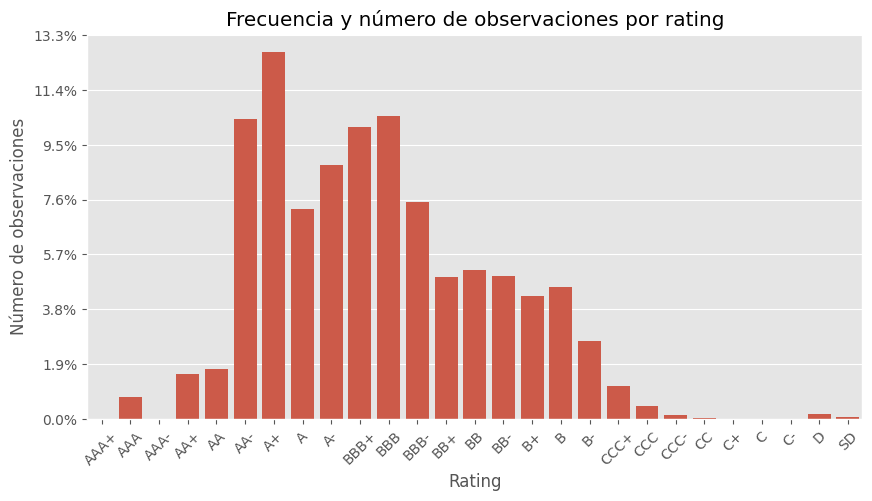

In [101]:
# make a column plot of the number of observations per rating with seaborn, showing the % not the total number of observations
plt.figure(figsize=(10, 5))
sns.countplot(x='Rating', data=df, order=All_rating_order)
plt.title('Frecuencia y número de observaciones por rating')
plt.ylabel('Número de observaciones')
plt.xlabel('Rating')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(len(df)))
plt.show()

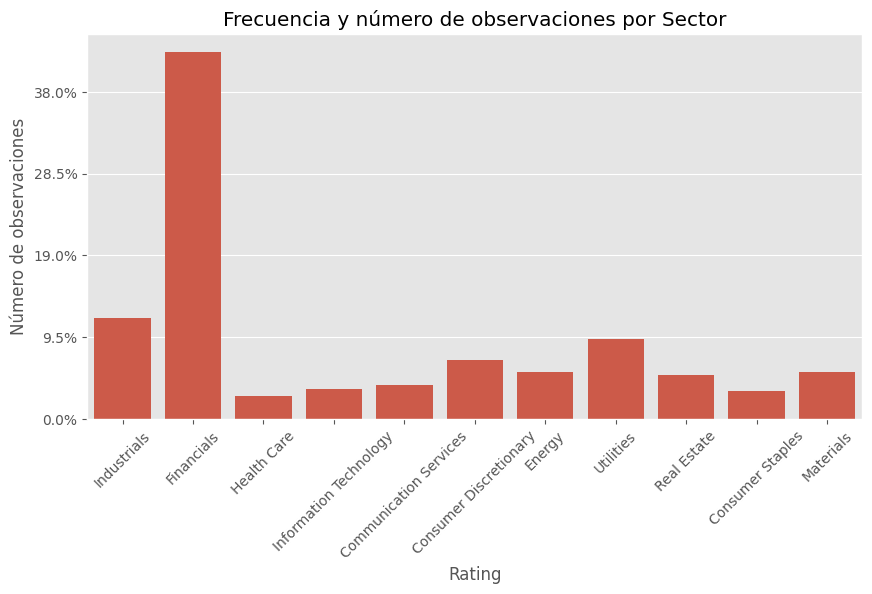

In [102]:
# make a column plot of the number of observations per rating with seaborn, showing the % not the total number of observations
plt.figure(figsize=(10, 5))
# plot the number of observations per sector different of 0
sns.countplot(x='Sector', data=df[df['Sector'] != '0'])
plt.title('Frecuencia y número de observaciones por Sector')
plt.ylabel('Número de observaciones')
plt.xlabel('Rating')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(len(df)))
plt.show()

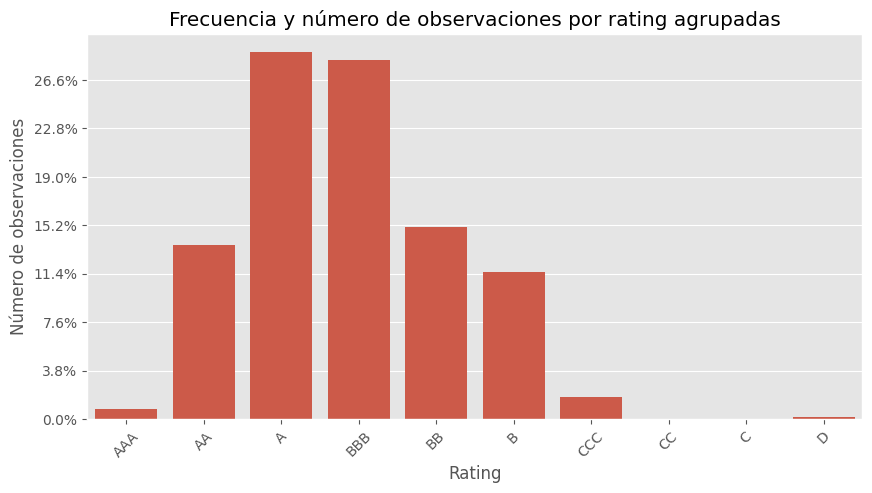

In [103]:
All_rating_order_group = {'AAA+':'AAA','AAA':'AAA','AAA-':'AAA',
                    'AA+':'AA','AA':'AA','AA-':'AA','A+':'A','A':'A','A-':'A',
                    'BBB+':'BBB','BBB':'BBB','BBB-':'BBB','BB+':'BB','BB':'BB','BB-':'BB','B+':'B','B':'B','B-':'B',
                    'CCC+':'CCC','CCC':'CCC','CCC-':'CCC','CC':'CC','C+':'C','C':'C','C-':'C','D':'D'}

# create a new column in the dataframe with the rating grouped
df['Rating_group'] = df['Rating'].map(All_rating_order_group)
# an plot the results by Rating_group
plt.figure(figsize=(10, 5))
sns.countplot(x='Rating_group', data=df, order=All_rating_order_group.values())
plt.title('Frecuencia y número de observaciones por rating agrupadas')
plt.ylabel('Número de observaciones')
plt.xlabel('Rating')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(len(df)))
plt.show()

XXXX Este desequilibrio en los datos provoca que el modelo simpre predice entorno a `BBB` por tanto tenemos que multiplicar los datos las otras categorias para poder tener un base de datos mas equilibrada.

In [104]:
"""df_duplicados = pd.DataFrame(df, copy=True)
All_rating_increase_dict = {k:0 for k in All_rating_order}

for rating in All_rating_order:
    All_rating_increase_dict[rating] = len(df_duplicados[df_duplicados.Rating == rating])

max_rating = max(All_rating_increase_dict.values())

for rating, v in All_rating_increase_dict.items():
    if v != 0 and v < 1300:
        numero_de_repeticiones = int(max_rating / v ) 
        All_rating_increase_dict[rating] = numero_de_repeticiones
        print("Duplicaciones:",rating,numero_de_repeticiones)
        for i in range(0,numero_de_repeticiones):
            df_duplicados = pd.concat([df_duplicados,df[df.Rating == rating]])

bar_grafica('Frecuencia y número de observaciones por rating con oversampling',
            All_rating_order,
            df_duplicados)"""

'df_duplicados = pd.DataFrame(df, copy=True)\nAll_rating_increase_dict = {k:0 for k in All_rating_order}\n\nfor rating in All_rating_order:\n    All_rating_increase_dict[rating] = len(df_duplicados[df_duplicados.Rating == rating])\n\nmax_rating = max(All_rating_increase_dict.values())\n\nfor rating, v in All_rating_increase_dict.items():\n    if v != 0 and v < 1300:\n        numero_de_repeticiones = int(max_rating / v ) \n        All_rating_increase_dict[rating] = numero_de_repeticiones\n        print("Duplicaciones:",rating,numero_de_repeticiones)\n        for i in range(0,numero_de_repeticiones):\n            df_duplicados = pd.concat([df_duplicados,df[df.Rating == rating]])\n\nbar_grafica(\'Frecuencia y número de observaciones por rating con oversampling\',\n            All_rating_order,\n            df_duplicados)'

En caso de querer trabajar con los datos dupliocamos ejecutamos el codigo siguiente:

In [105]:
#df = df_duplicados

## Estudio de los datos

Primero analizamos por una categoría un poco más amplia

In [106]:
df = df.replace([np.inf, -np.inf], np.nan)
df.dropna(subset=var_x_num, inplace=True)
# drop the rows with inf values
var_x_num+['Rating_group']
# remove the column Company Name from the list of columns
del df['Company Name']
df


,Excel Company ID,Rating,Sector,Current Assets,Cash and equivalents,Receivables,Total Assets,Current Liabilities,Long Term Debt,Total Debt,...,Net Debt to EBITDA,Debt to Assets,Current Ratio,Quick Ratio,Cash ratio,Long Term Debt to Equity,Debt to Equity,Debt ratio,Financial Leverage,Rating_group
1274,IQ4149300,BBB,Industrials,1386.394130,473.542210,564.48206,4850.440190,401.584150,557.975480,663.115710,...,0.711890,0.159156,3.452313,2.584824,1.179186,0.159270,0.189282,7.314621,1.384523,BBB
2392,IQ5522615,AAA,Industrials,131.886220,40.311420,79.35595,948.460220,375.106820,140.048780,298.030420,...,1.942794,0.449078,0.351596,0.319022,0.107467,0.383045,0.815138,3.182428,2.594117,AAA
2395,IQ4112645,AAA,Industrials,19851.156570,1694.929070,17057.47764,59124.558260,12387.790770,36441.358610,43611.622140,...,16.539510,0.975040,1.602478,1.513781,0.136823,32.641924,39.064605,1.355706,52.960138,AAA
2400,IQ5490337,AAA,Industrials,434.871000,258.081000,152.57500,1399.966000,209.398000,333.805000,333.941000,...,0.333653,-0.899933,2.076768,1.961127,1.232490,-0.473473,-0.473666,4.192256,-1.985728,AAA
2404,IQ134385765,AAA,Financials,56290.371000,382.955000,53255.75500,187664.387000,125659.115000,58822.436000,159460.406000,...,19.803120,0.999257,0.447961,0.426859,0.003048,495.781029,1344.001534,1.176871,1581.716931,AAA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82823,IQ270999467,B+,Communication Services,591.637496,212.759466,41.56473,668.616599,121.325669,506.736756,523.997614,...,3.325927,0.951378,4.876441,2.096211,1.753623,18.922397,19.566946,1.275992,24.967261,B
82824,IQ215548781,BBB,Health Care,7023.364200,3350.741700,1136.87550,13965.322500,2963.361900,6160.648800,7639.990500,...,1.375750,0.649666,2.370066,1.514367,1.130723,1.495344,1.854417,1.827924,3.389734,BBB
82825,IQ656458081,BB,Communication Services,778.502400,391.122600,219.14094,6677.529480,535.875390,1156.244490,1229.416230,...,4.021095,0.366428,1.452768,1.138816,0.729876,0.543930,0.578352,5.431464,3.141298,BB
82834,IQ26972760,AA,Financials,81389.993100,6681.833700,8388.55050,356234.089800,53667.073500,12177.199800,16603.060800,...,1.525392,0.380487,1.516572,0.280812,0.124505,0.450452,0.614171,21.455929,13.177599,AA


Ahora vemos la distribución de nuestro datos. Pero antes un pequeño estudio de como vamos perdiendo datos a medida de que quitamos los extremos.

In [107]:
# filter the data deleting the outliers 
list_of_percentiles = [100,99,97.5,95,92.5,90,85,80]
dict_percentiles = {}
for percentile in list_of_percentiles:
    for col in var_x_num:
        percentile_value = np.percentile(df[col], percentile)
        if col in dict_percentiles:
            dict_percentiles[col].append(int(df[df[col] <= percentile_value].shape[0]))
        else:
            dict_percentiles[col] = [int(df[df[col] <= percentile_value].shape[0])]

dict_percentiles['Percentile'] = list_of_percentiles
pd.DataFrame.from_dict(dict_percentiles)

,Net Debt to EBITDA,Debt to Assets,Current Ratio,Quick Ratio,Cash ratio,Long Term Debt to Equity,Debt to Equity,Debt ratio,Financial Leverage,Percentile
0,31804,31804,31804,31804,31804,31804,31804,31804,31804,100.0
1,31485,31485,31485,31485,31485,31485,31485,31485,31485,99.0
2,31008,31008,31008,31008,31008,31008,31008,31008,31008,97.5
3,30213,30213,30213,30213,30213,30213,30213,30213,30213,95.0
4,29418,29418,29419,29418,29418,29418,29418,29418,29418,92.5
5,28623,28623,28623,28623,28623,28623,28623,28623,28623,90.0
6,27033,27033,27033,27033,27033,27033,27033,27033,27033,85.0
7,25443,25443,25443,25443,25443,25443,25443,25443,25443,80.0


Como algunos de las ratios tiene mucha dispersion tenemos que ver como reducirlos:


1) Net Debt to EBTIDA, conocido como Leverage Ratio no dice cuantas veces tu deuda total es tu EBITDA, de esta forma podemos saber cuantos años necesitas para pagar tu deuda de manera aproximada.
2) Debt to Assets, esto debería de ser un % que vaya de 0 a 100% reflejando el apalancamiento de la compañía, analizaremos el numerodos y denominados
3) Esto debería también ser un un % que vaya de 0 a un numero menos 100%, analizaremos el numerodos y denominados
4) Debt to equity, esto debería de ser un % que vaya de 0 a 100% reflejando el ¿? de la compañía, analizaremos el numerodos y denominados
5) Financial Leverage, deberia ir de 0 a 100%


### Net Debt to EBITDA

1) Net Debt to EBTIDA, conocido como Leverage Ratio no dice cuantas veces tu deuda total es tu EBITDA, de esta forma podemos saber cuantos años necesitas para pagar tu deuda de manera aproximada. El problema es que:
    - El EBTIDA puede estar cerca de 0, lo cual dispararía el valor tanto a +inf como -inf.
    - La Deuda neta puede ser 0 o negativa ya que puedes tener más caja que deuda, aunque esto no es muy frecuenta.

    Por tanto, vamos a:
    - EBITDA > 0 y Net Debt > 0 -> dejar el dato como esta. Y poner un maximo apartir del cual ya no pueda ser peor.
    - EBITDA > 0 y Net Debt < 0 -> Poner un 0 ya que esté sería el mejor escenario
    - EBITDA < 0 y Net Debt < 0 -> Este sería el peor caso asi que tendremos que poner un valor y definir este como el maximo.
    - EBITDA < 0 y Net Debt > 0 -> Este es un caso raro, veremos cuantos hay.


In [108]:
# compute the stadistics
df['Net Debt'] = df["Total Debt"] - df["Cash and equivalents"]
df.describe()

,Current Assets,Cash and equivalents,Receivables,Total Assets,Current Liabilities,Long Term Debt,Total Debt,Total Equity,Gastos financieros netos,EBITDA,...,Net Debt to EBITDA,Debt to Assets,Current Ratio,Quick Ratio,Cash ratio,Long Term Debt to Equity,Debt to Equity,Debt ratio,Financial Leverage,Net Debt
count,3.180400e+04,3.180400e+04,3.180400e+04,3.180400e+04,3.180400e+04,3.180400e+04,3.180400e+04,3.180400e+04,31804.000000,3.180400e+04,...,31804.000000,31804.000000,31804.000000,31804.000000,31804.000000,3.180400e+04,3.180400e+04,3.180400e+04,3.180400e+04,3.180400e+04
mean,7.436707e+03,1.385232e+03,2.164792e+03,2.574133e+04,6.463804e+03,7.572729e+03,9.177893e+03,2.709011e+03,-163.626930,1.277386e+03,...,2.211630,0.531193,3.697774,2.827609,0.667705,3.349716e+06,3.786802e+06,1.160292e+03,1.636661e+07,7.792661e+03
std,4.646230e+04,1.020540e+04,2.275476e+04,8.528010e+04,5.906428e+04,2.338828e+05,2.340867e+05,3.167924e+05,574.795624,3.407352e+04,...,324.991762,1.652389,189.267355,189.046822,22.626783,3.455330e+08,3.907657e+08,1.386482e+05,1.686120e+09,2.265279e+05
min,-1.666357e+03,-1.689010e+00,-3.291152e+00,7.438200e-01,1.810000e-02,-1.712520e+00,5.450000e-04,-3.473561e+07,-25093.483631,-4.141102e+06,...,-23674.895570,-169.392654,-1.810261,0.000000,-0.012686,-1.548405e+04,-2.058106e+04,1.958755e-03,-2.950109e+04,-5.825240e+04
25%,4.047912e+02,5.727733e+01,1.179098e+02,2.379313e+03,3.150776e+02,5.680718e+02,7.252960e+02,6.526799e+02,-162.146100,1.782355e+02,...,1.286739,0.335428,0.866444,0.459648,0.098700,3.103826e-01,4.258247e-01,2.064387e+00,1.988365e+00,4.353959e+02
50%,1.317724e+03,2.614774e+02,3.881558e+02,6.281265e+03,9.859296e+02,1.590576e+03,2.008768e+03,1.957915e+03,-58.609646,5.004876e+02,...,2.972850,0.486855,1.270116,0.760971,0.252840,6.799904e-01,8.535052e-01,2.909251e+00,2.735626e+00,1.472114e+03
75%,4.598304e+03,9.881602e+02,1.324555e+03,1.869849e+04,3.562837e+03,4.330507e+03,5.456339e+03,6.059902e+03,-19.794183,1.465355e+03,...,5.385113,0.645274,1.895173,1.168547,0.530431,1.229207e+00,1.542019e+00,4.534653e+00,4.070094e+00,4.225824e+03
max,3.769182e+06,1.511420e+06,1.825850e+06,5.071874e+06,6.588928e+06,2.480969e+07,2.480969e+07,4.527779e+05,8883.029026,1.342614e+05,...,37204.447972,204.905106,28923.495028,28923.495028,3866.797939,3.852078e+10,4.395618e+10,2.431233e+07,1.785409e+11,2.417670e+07


- EBITDA > 0 y Net Debt > 0 -> dejar el dato como esta y ponemos un maximo apartir del cual ya no se pueda hacer.

In [109]:
mask = (df['EBITDA']>0) & (df['Net Debt']>0)
df[mask][['EBITDA','Net Debt','Net Debt to EBITDA','Rating_group']].describe()


,EBITDA,Net Debt,Net Debt to EBITDA
count,28380.000000,28380.000000,28380.000000
mean,1728.461499,5513.428367,10.208148
std,4370.646166,14317.395011,245.535196
min,0.026747,0.002090,0.000197
25%,205.352940,629.409915,1.809177
50%,530.115323,1734.007568,3.372772
75%,1514.773981,4687.797585,5.734721
max,134261.418500,658523.103250,37204.447972


<Figure size 1000x500 with 0 Axes>

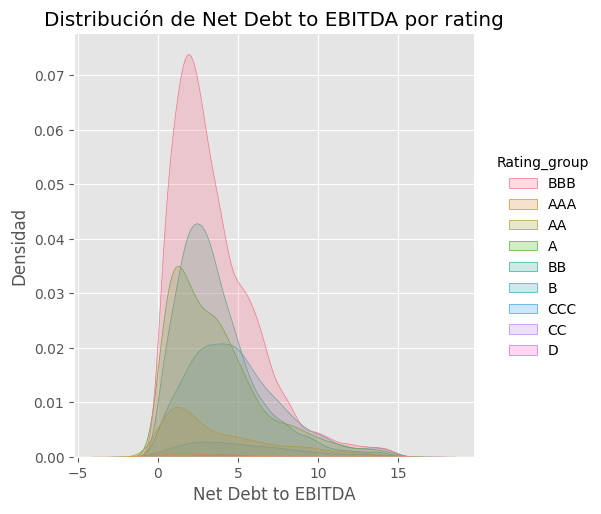

In [110]:
# plot the distrubution of tne column 'EBITDA' with displot by rating_group
variable = 'Net Debt to EBITDA'
percentile = 95
df_test = df[mask][['EBITDA','Net Debt','Net Debt to EBITDA','Rating_group']]
# filter the data by the percentile 95
df_test = df_test[df_test[variable] <= np.percentile(df_test[variable], percentile)]

plt.figure(figsize=(10, 5))
sns.displot(data=df_test, x=variable, hue='Rating_group', kind='kde', fill=True)
plt.title(f'Distribución de {variable} por rating')
plt.xlabel(variable)
plt.ylabel('Densidad')
plt.show()

15 parece el el valor maáximo asi que cortaremos en 15

In [111]:
np.percentile(df[variable], 95)

13.929849696681842

In [112]:
df['Net Debt to EBITDA'].describe()

count    31804.000000
mean         2.211630
std        324.991762
min     -23674.895570
25%          1.286739
50%          2.972850
75%          5.385113
max      37204.447972
Name: Net Debt to EBITDA, dtype: float64

In [115]:
mask = (df[variable] >= np.percentile(df[variable], percentile)) & (df['EBITDA']>0) & (df['Net Debt']>0)
df.loc[mask,'Net Debt to EBITDA'].describe()

count     1557.000000
mean       120.773800
std       1042.342085
min         13.929903
25%         17.393646
50%         24.469771
75%         45.650400
max      37204.447972
Name: Net Debt to EBITDA, dtype: float64

In [116]:
df.loc[mask,'Net Debt to EBITDA'] = 15
df['Net Debt to EBITDA'].describe()

count    31804.000000
mean        -2.966643
std        227.498232
min     -23674.895570
25%          1.286739
50%          2.972850
75%          5.385113
max       3905.711376
Name: Net Debt to EBITDA, dtype: float64

- EBITDA > 0 y Net Debt < 0 -> Poner un 0 ya que esté sería el mejor escenario

In [117]:
mask = (df['EBITDA']>0) & (df['Net Debt']<=0)
df[mask][['EBITDA','Net Debt','Net Debt to EBITDA','Rating_group']]

,EBITDA,Net Debt,Net Debt to EBITDA,Rating_group
2407,16813.727950,-1975.309950,-0.117482,AAA
2428,14045.193300,-7994.185350,-0.569176,AA
2437,1215.006740,-1374.833130,-1.131544,AA
2482,424.797750,-1209.765900,-2.847863,AA
2484,165.281520,-10.807660,-0.065389,AA
...,...,...,...,...
82641,510.272767,-190.688175,-0.373699,BBB
82663,2996.111400,-585.748200,-0.195503,BBB
82746,1443.574898,-287.512157,-0.199167,BBB
82758,1157.762023,-173.581901,-0.149929,BBB


In [118]:
# over write all the row values of the column 'Net Debt to EBITDA' that are in mask with 0
df.loc[mask,'Net Debt to EBITDA'] = 0
df['Net Debt to EBITDA'].describe()

count    31804.000000
mean        -2.567864
std        226.682255
min     -23674.895570
25%          1.286739
50%          2.972850
75%          5.385113
max       3905.711376
Name: Net Debt to EBITDA, dtype: float64

- EBITDA < 0 y Net Debt > 0 -> Este sería el peor caso asi que tendremos que poner el valor maximo que hemos definido

In [119]:
mask = (df['EBITDA']<0) & (df['Net Debt']>0)
df[mask][['EBITDA','Net Debt','Net Debt to EBITDA']]


,EBITDA,Net Debt,Net Debt to EBITDA
2749,-2.199290,35.414660,-16.102770
3108,-1363.698760,10000.141510,-7.333102
3534,-431.980560,8814.551900,-20.404974
3564,-251.271780,18676.888500,-74.329431
3634,-5.859180,200.074990,-34.147268
...,...,...,...
82051,-444.240754,12061.110425,-27.149941
82636,-112.005654,1556.372869,-13.895485
82686,-492.178200,18224.628900,-37.028517
82751,-294.571196,4917.014158,-16.692108


In [120]:
df.loc[mask,'Net Debt to EBITDA'] = 15
df['Net Debt to EBITDA'].describe()

count    31804.000000
mean         4.543531
std         22.784034
min          0.000000
25%          1.462123
50%          3.173790
75%          5.754098
max       3905.711376
Name: Net Debt to EBITDA, dtype: float64

- EBITDA < 0 y Net Debt < 0 -> Este sería el caso más raro, pero pasa?

In [121]:
mask = (df['EBITDA']<0) & (df['Net Debt']<0)
df[mask][['EBITDA','Net Debt','Net Debt to EBITDA','Rating_group']].describe()

,EBITDA,Net Debt,Net Debt to EBITDA
count,162.000000,162.000000,162.000000
mean,-407.015603,-987.816390,42.778005
std,943.247955,1953.583588,312.698594
min,-6755.349082,-17321.639613,0.001335
25%,-300.677572,-916.424331,0.872052
50%,-131.463770,-314.217319,2.696894
75%,-32.709937,-69.177815,11.070002
max,-0.031910,-0.019000,3905.711376


Eliminamos estos casos raros

In [122]:
print(df.shape)
df = df[~mask]
df['Net Debt to EBITDA'].describe()

(31804, 25)


count    31642.000000
mean         4.347779
std          4.087487
min          0.000000
25%          1.466770
50%          3.174894
75%          5.744131
max         15.000000
Name: Net Debt to EBITDA, dtype: float64

vemos la distribucion por rating

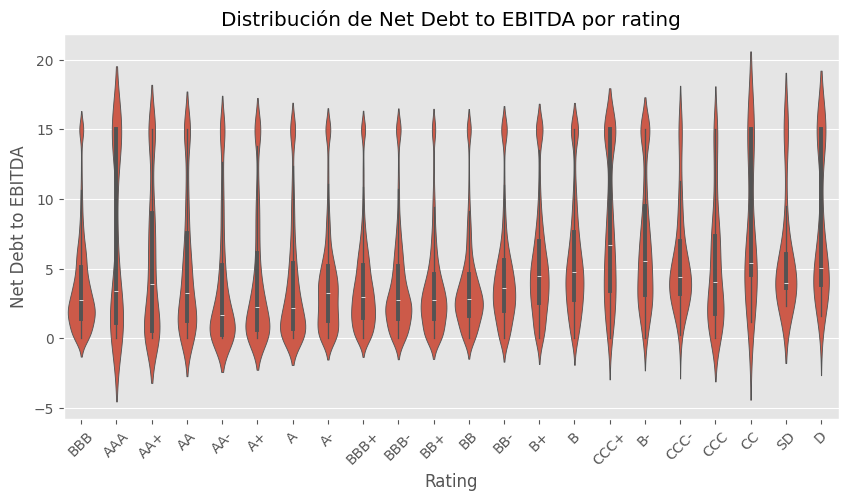

In [124]:
# violin plot of the column 'Net Debt to EBITDA' by rating_group
plt.figure(figsize=(10, 5))
sns.violinplot(x='Rating', y='Net Debt to EBITDA', data=df)
plt.title('Distribución de Net Debt to EBITDA por rating')
plt.xlabel('Rating')
plt.ylabel('Net Debt to EBITDA')
plt.xticks(rotation=45)
plt.show()

XXX Pensar que hacer para no distorsionar la media poniedo el maximo en 15 para esos dos casos.

### Debt to assets
2) Debt to Assets, esto debería de ser un % que vaya de 0 a 100% reflejando el apalancamiento de la compañía, analizaremos el numerodos y denominados

In [148]:
variable = 'Debt to Assets'
df[[variable,'Total Debt','Total Assets', 'Total Equity']].describe()

,Debt to Assets,Total Debt,Total Assets,Total Equity
count,3.005000e+04,30050.000000,3.005000e+04,30050.000000
mean,4.769435e-01,6123.332472,2.584475e+04,7197.404692
std,2.144752e-01,13729.030151,6.739918e+04,17727.563460
min,8.096740e-07,0.000545,3.729932e+00,0.000001
25%,3.294131e-01,724.171600,2.513052e+03,801.869413
50%,4.743472e-01,2024.828125,6.610644e+03,2197.280850
75%,6.163233e-01,5502.953107,1.944673e+04,6457.582375
max,1.000000e+00,278873.832930,1.415340e+06,452777.949000


Borramos todos los que tengas equity negatio

In [149]:
print(df.shape)
df = df[df['Total Equity']>=0]

(30050, 25)


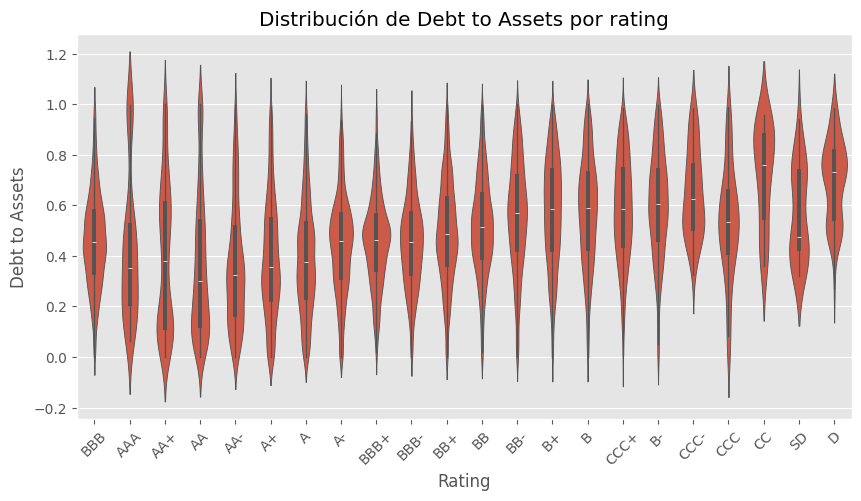

In [151]:
# violin plot of the column varaible by rating
plt.figure(figsize=(10, 5))
sns.violinplot(x='Rating', y=variable, data=df)
plt.title(f'Distribución de {variable} por rating')
plt.xlabel('Rating')
plt.ylabel(variable)
plt.xticks(rotation=45)
plt.show()

XXX investigar porque se ven valores menors que 0 y mayores que 1 en el grafico cuando en el fondo no hay

### Long Term Debt to equity 
3) Te dice cuantas veces tu LT Debt es tu equity, asi que deberá de ser un %. Puede ir desde 0 (en caso de no tener LT Debt) hasta inf (pero lo limitaremos igual euigual que el Debt to EBTIDA=). The goal of this ratio is to determine how much leverage the company is taking. A higher ratio means the company is taking on more debt. This, in turn, often makes them more prone to financial risk.


In [154]:
variable = 'Long Term Debt to Equity'
df[[variable,'Long Term Debt', 'Total Equity']].describe()

,Long Term Debt to Equity,Long Term Debt,Total Equity
count,3.005000e+04,30050.000000,30050.000000
mean,3.545238e+06,4478.399395,7197.404692
std,3.554737e+08,9141.680280,17727.563460
min,-1.138845e-03,-1.712520,0.000001
25%,3.663032e-01,564.706815,801.869413
50%,7.241770e-01,1603.997400,2197.280850
75%,1.285001e+00,4332.510479,6457.582375
max,3.852078e+10,162672.380700,452777.949000


No puede ser negativo

In [155]:
sum(df['Long Term Debt']<0)

1

In [156]:
df = df[df['Long Term Debt']>=0]

4.5938705069204175


<Figure size 1000x500 with 0 Axes>

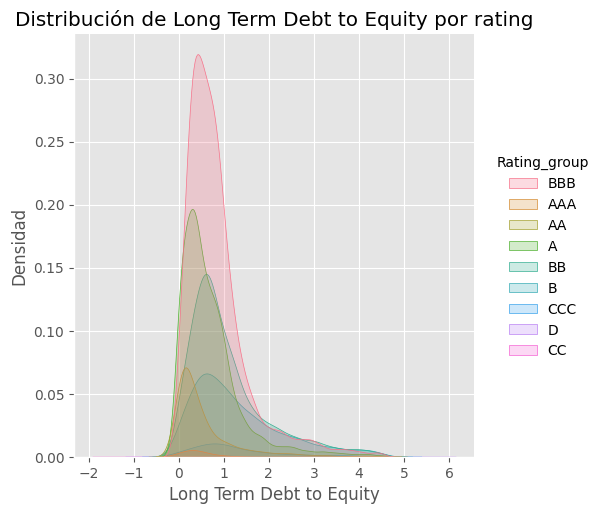

In [159]:
percentile = 95
df_test = df
#df_test = df[mask][['EBITDA','Net Debt','Net Debt to EBITDA','Rating_group']]
# filter the data by the percentile 95
value_percentile = np.percentile(df_test[variable], percentile)
print(value_percentile)
df_test = df_test[df_test[variable] <= value_percentile]


plt.figure(figsize=(10, 5))
sns.displot(data=df_test, x=variable, hue='Rating_group', kind='kde', fill=True)
plt.title(f'Distribución de {variable} por rating')
plt.xlabel(variable)
plt.ylabel('Densidad')
plt.show()

Lo limitamos en 5

In [160]:
df.loc[df[variable] >= value_percentile, variable] = value_percentile
df[variable].describe()

count    30049.000000
mean         1.091442
std          1.138036
min          0.000000
25%          0.366322
50%          0.724205
75%          1.285011
max          4.593871
Name: Long Term Debt to Equity, dtype: float64

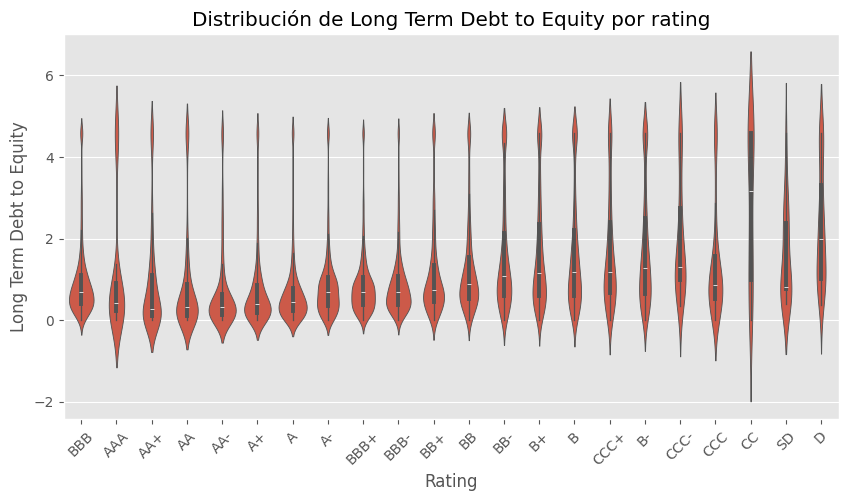

In [161]:
# violin plot of the column varaible by rating
plt.figure(figsize=(10, 5))
sns.violinplot(x='Rating', y=variable, data=df)
plt.title(f'Distribución de {variable} por rating')
plt.xlabel('Rating')
plt.ylabel(variable)
plt.xticks(rotation=45)
plt.show()

### Debt to equity
4) Debt to equity, esto debería de ser un % que vaya de 0 a 100% reflejando el ¿? de la compañía, analizaremos el numerodos y denominados

In [162]:
variable = 'Debt to Equity'
df[[variable,'Total Debt', 'Total Equity']].describe()

,Debt to Equity,Total Debt,Total Equity
count,3.004900e+04,30049.000000,30049.000000
mean,4.007971e+06,6123.535165,7197.594172
std,4.020143e+08,13729.213637,17727.828015
min,8.096746e-07,0.000545,0.000001
25%,4.912941e-01,724.445140,801.868000
50%,9.024022e-01,2024.927000,2197.282000
75%,1.606428e+00,5503.049290,6457.752000
max,4.395618e+10,278873.832930,452777.949000


5.753374503870499


<Figure size 1000x500 with 0 Axes>

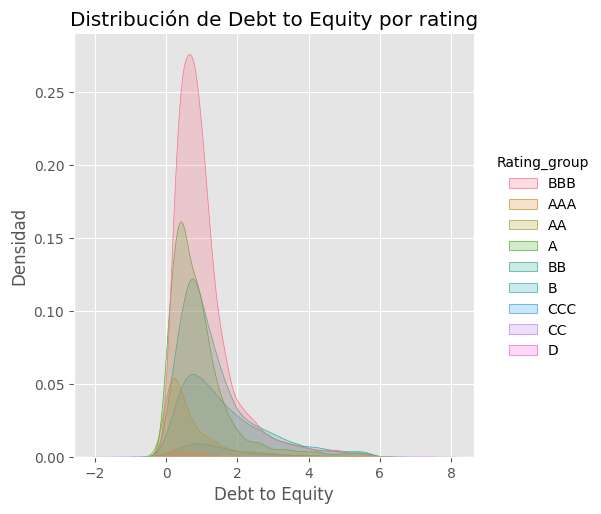

In [164]:
percentile = 95
df_test = df
#df_test = df[mask][['EBITDA','Net Debt','Net Debt to EBITDA','Rating_group']]
# filter the data by the percentile 95
value_percentile = np.percentile(df_test[variable], percentile)
print(value_percentile)
df_test = df_test[df_test[variable] <= value_percentile]


plt.figure(figsize=(10, 5))
sns.displot(data=df_test, x=variable, hue='Rating_group', kind='kde', fill=True)
plt.title(f'Distribución de {variable} por rating')
plt.xlabel(variable)
plt.ylabel('Densidad')
plt.show()

In [165]:
df.loc[df[variable] >= value_percentile, variable] = value_percentile
df[variable].describe()

count    3.004900e+04
mean     1.375155e+00
std      1.407449e+00
min      8.096746e-07
25%      4.912941e-01
50%      9.024022e-01
75%      1.606428e+00
max      5.753375e+00
Name: Debt to Equity, dtype: float64

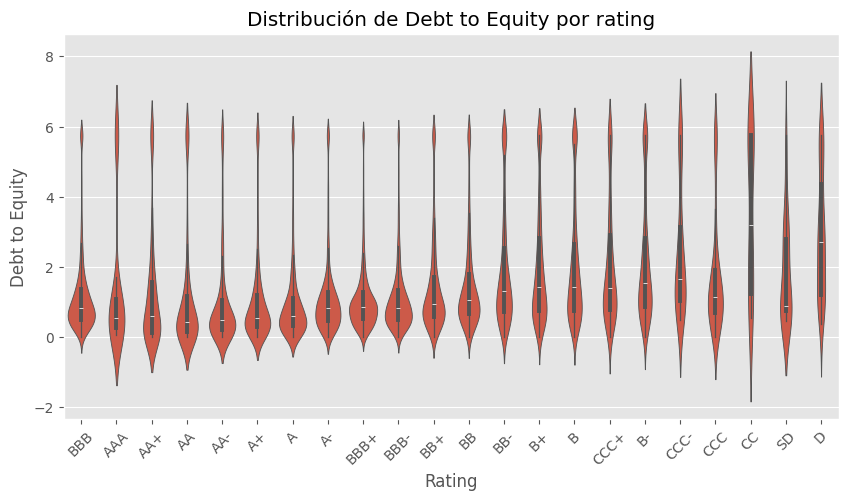

In [166]:
# violin plot of the column varaible by rating
plt.figure(figsize=(10, 5))
sns.violinplot(x='Rating', y=variable, data=df)
plt.title(f'Distribución de {variable} por rating')
plt.xlabel('Rating')
plt.ylabel(variable)
plt.xticks(rotation=45)
plt.show()

### Financila Leverage 
5) Financial Leverage, deberia ir de 0 a 100%

In [169]:
variable = 'Financial Leverage'
df[[variable,'Total Assets', 'Total Debt']].describe()

,Financial Leverage,Total Assets,Total Debt
count,3.004900e+04,3.004900e+04,30049.000000
mean,1.732250e+07,2.584551e+04,6123.535165
std,1.734657e+09,6.740017e+04,13729.213637
min,9.481179e-01,3.729932e+00,0.000545
25%,2.088673e+00,2.512995e+03,724.445140
50%,2.818740e+00,6.610711e+03,2024.927000
75%,4.190241e+00,1.944702e+04,5503.049290
max,1.785409e+11,1.415340e+06,278873.832930


14.88609354371364


<Figure size 1000x500 with 0 Axes>

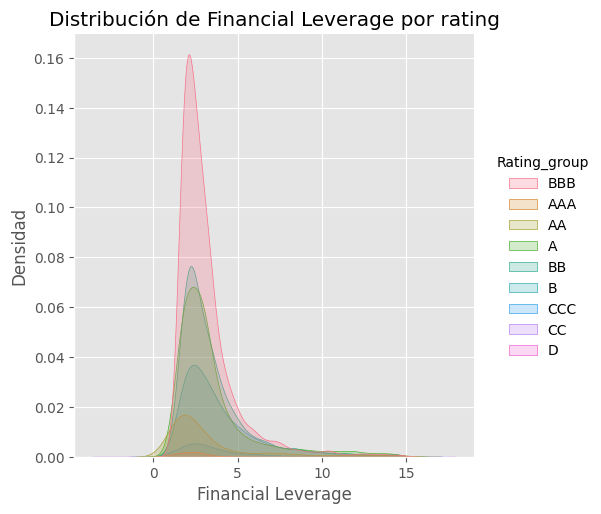

In [168]:
percentile = 95
df_test = df
#df_test = df[mask][['EBITDA','Net Debt','Net Debt to EBITDA','Rating_group']]
# filter the data by the percentile 95
value_percentile = np.percentile(df_test[variable], percentile)
print(value_percentile)
df_test = df_test[df_test[variable] <= value_percentile]


plt.figure(figsize=(10, 5))
sns.displot(data=df_test, x=variable, hue='Rating_group', kind='kde', fill=True)
plt.title(f'Distribución de {variable} por rating')
plt.xlabel(variable)
plt.ylabel('Densidad')
plt.show()

In [170]:
df.loc[df[variable] >= value_percentile, variable] = value_percentile
df[variable].describe()

count    30049.000000
mean         4.003575
std          3.324402
min          0.948118
25%          2.088673
50%          2.818740
75%          4.190241
max         14.886094
Name: Financial Leverage, dtype: float64

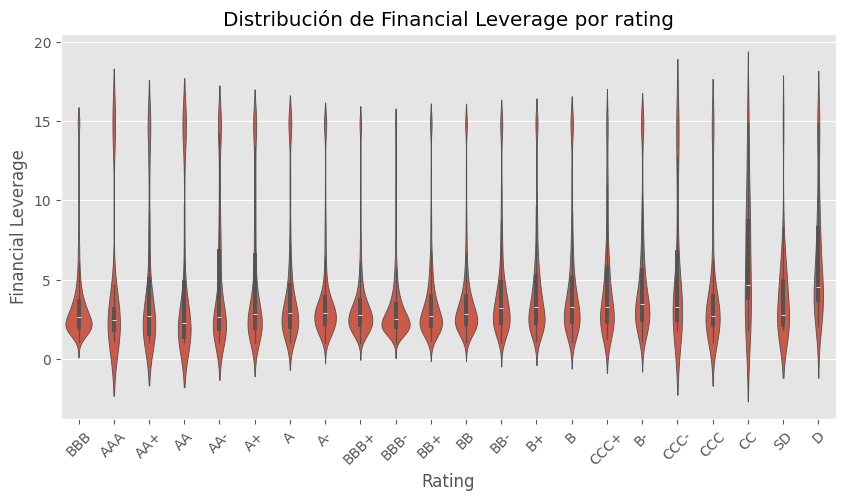

In [171]:
# violin plot of the column varaible by rating
plt.figure(figsize=(10, 5))
sns.violinplot(x='Rating', y=variable, data=df)
plt.title(f'Distribución de {variable} por rating')
plt.xlabel('Rating')
plt.ylabel(variable)
plt.xticks(rotation=45)
plt.show()

In [173]:
percentile

95

In [177]:
ratios_to_delete_extrems = {'Current Ratio':95,'Quick Ratio':95,'Cash ratio':95,'Debt ratio':90}
for ratio,percentile  in ratios_to_delete_extrems.items():
    mask = df[ratio] < np.percentile(df[ratio], percentile)
    print(ratio,df[~mask].shape)
    df = df[mask]

Current Ratio (1503, 25)
Quick Ratio (1428, 25)
Cash ratio (1356, 25)
Debt ratio (1289, 25)


In [179]:
df.shape

(24473, 25)

In [182]:
var_x_num

['Net Debt to EBITDA',
 'Debt to Assets',
 'Current Ratio',
 'Quick Ratio',
 'Cash ratio',
 'Long Term Debt to Equity',
 'Debt to Equity',
 'Debt ratio',
 'Financial Leverage']

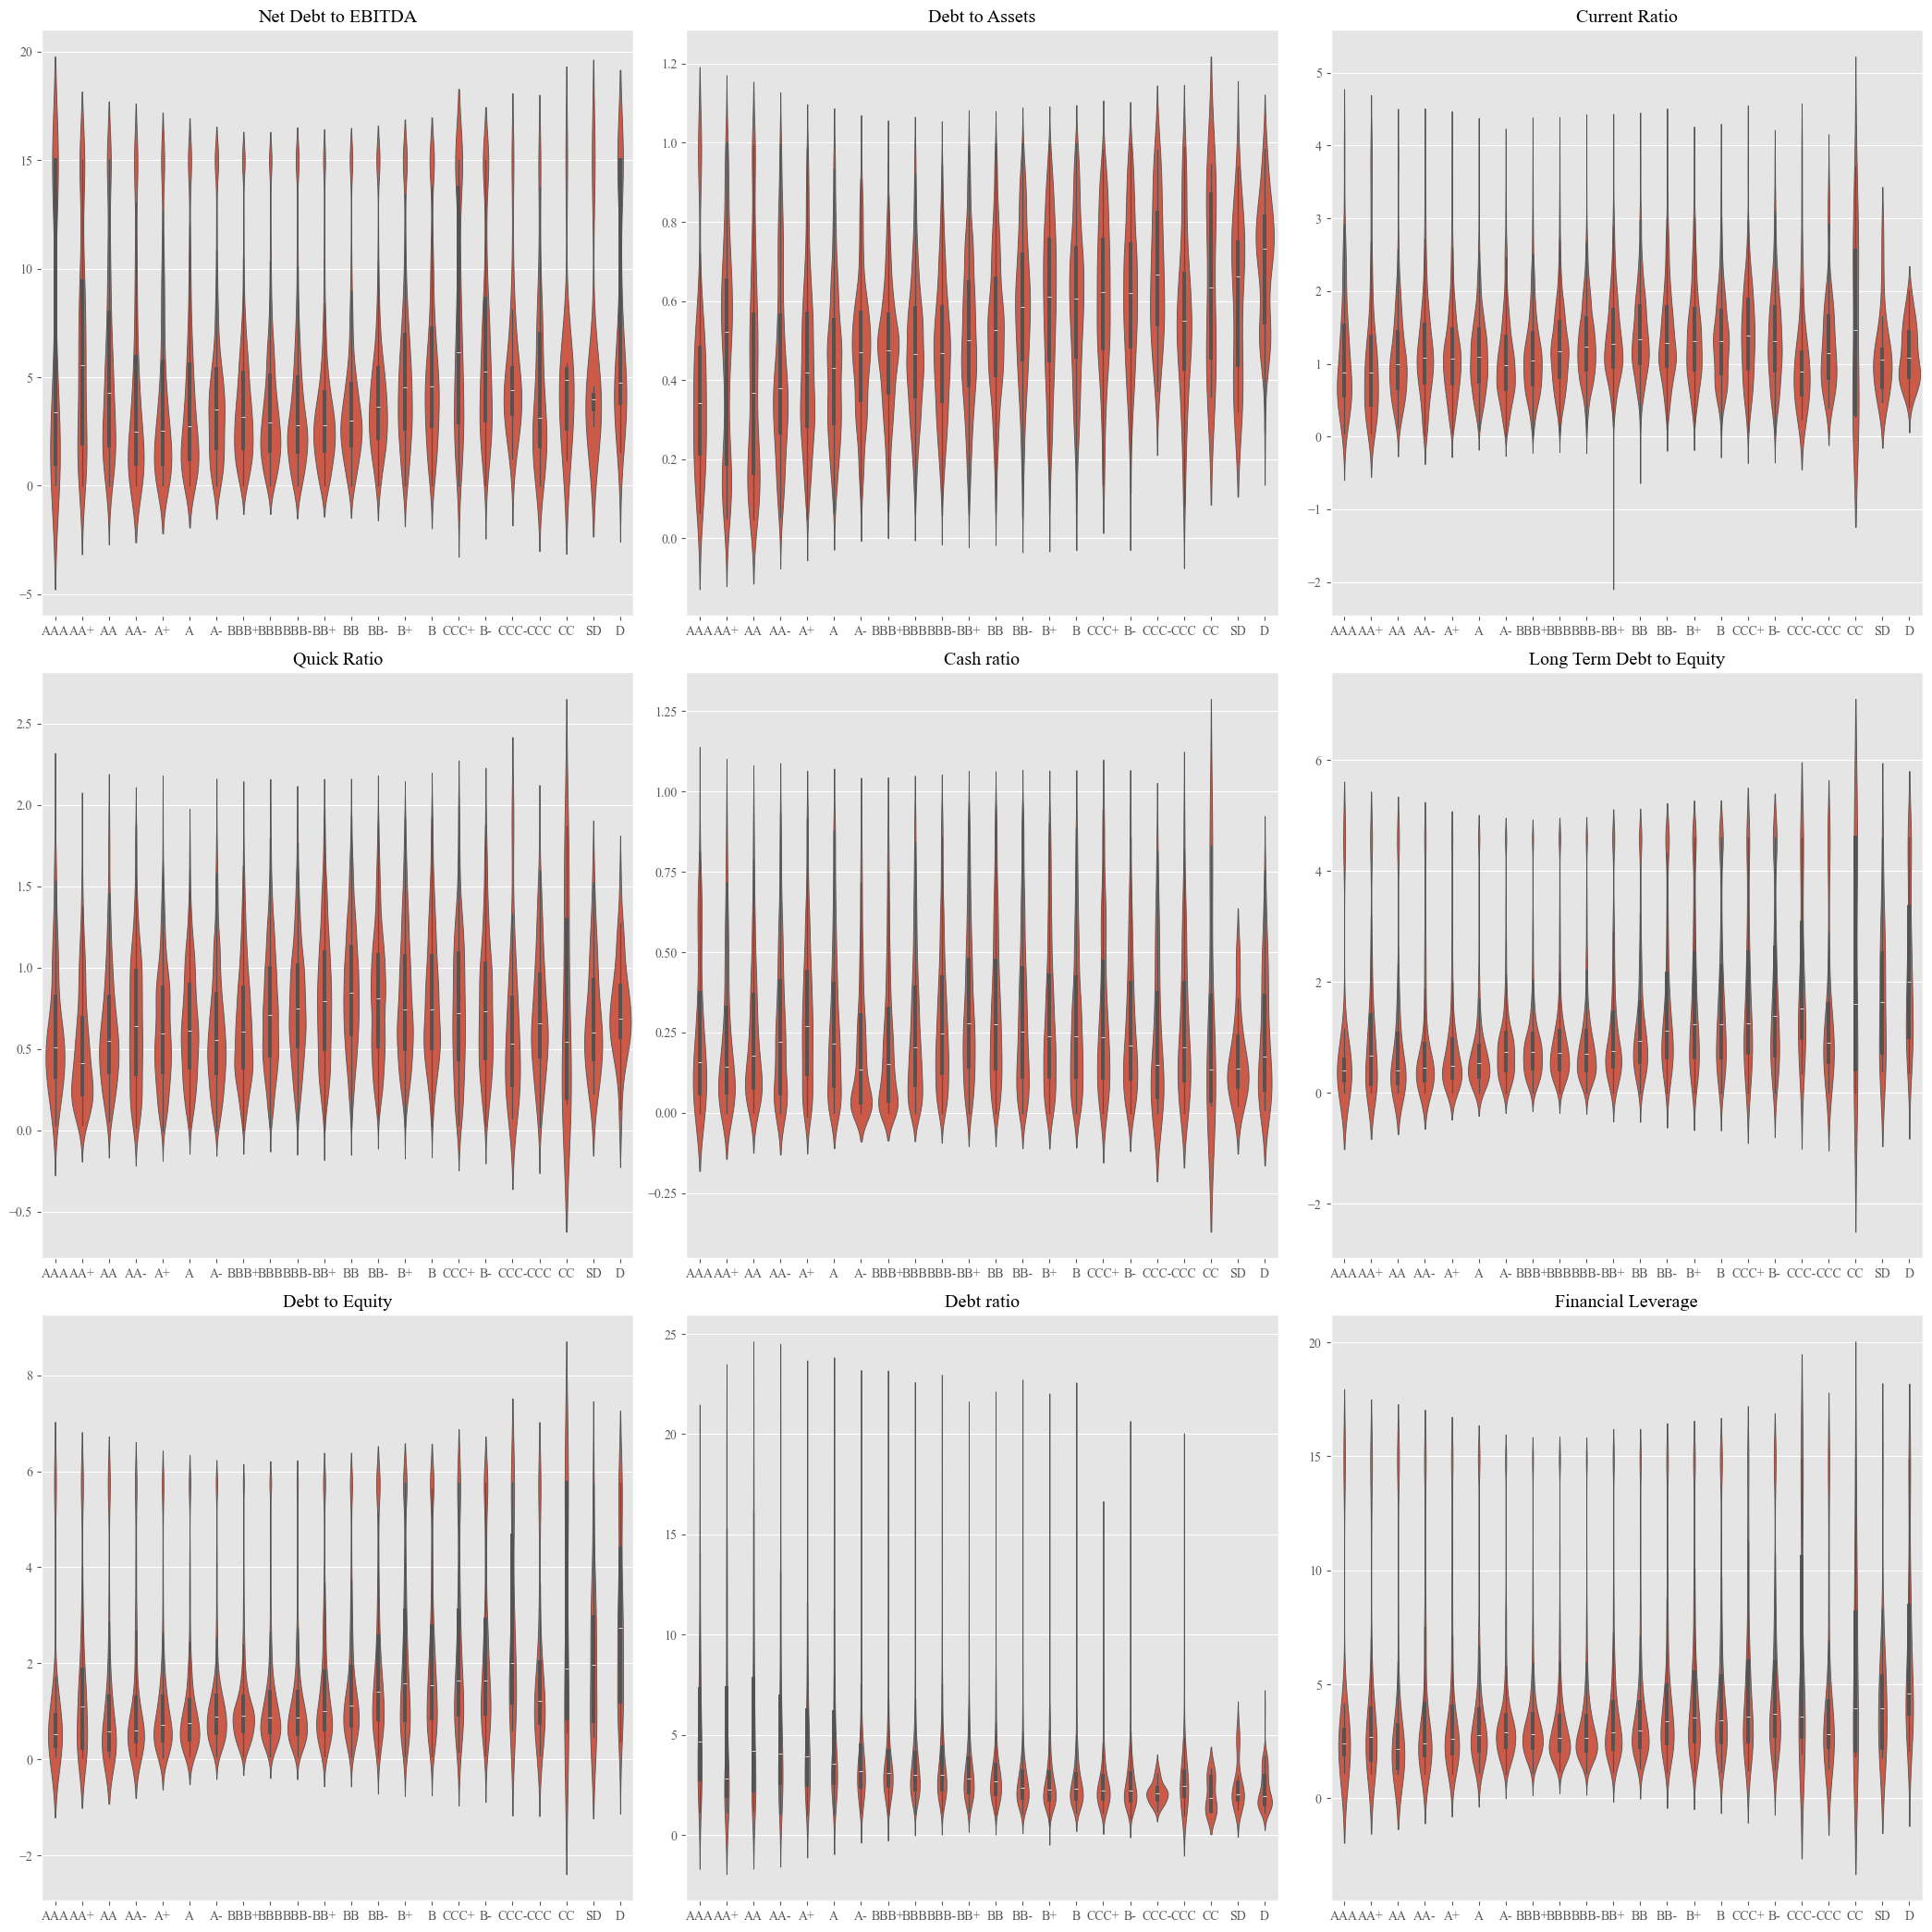

In [184]:
#Gráfico con la distribución de los datos por Rating
fig, axes = plt.subplots(3, 3, figsize=(7*3, 7*3))
# change the font size to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

for i, y in enumerate(var_x_num):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    sns.violinplot(x='Rating', y=y, data=df, ax=ax)
    # dont show the x and y title
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(y)

plt.tight_layout()
plt.show()

    

In [111]:
# pensar los rangos en los que se deberían de mover cada uno y ver entorno a cuales se mueven

df_all["Net Debt to EBITDA"] = (df_all["Total Debt"] - df_all["Cash and equivalents"]) / df_all["EBITDA"]
df_all["Debt to Assets"] = df_all["Total Debt"] / (df_all["Total Equity"]+df_all["Total Debt"])
df_all["Long Term Debt to Equity"] = df_all["Long Term Debt"] / df_all["Total Equity"]
df_all["Debt to Equity"] = df_all["Total Debt"] / df_all["Total Equity"]
df_all["Financial Leverage"] = df_all["Total Assets"] / df_all["Total Equity"]

df_all["Current Ratio"] = df_all["Current Assets"] / df_all["Current Liabilities"]
df_all["Quick Ratio"] = (df_all["Cash and equivalents"] + df_all["Receivables"]) / df_all["Current Liabilities"]
df_all["Cash ratio"] = df_all["Cash and equivalents"] / df_all["Current Liabilities"]
df_all["Debt ratio"] = df_all["Total Assets"] / df_all["Total Debt"]


Por ahora vamos a meter todas las variables pero parece que hay algunas que no van a funcionar, pero puede que al meter el sector mejoren. Por tanto ahora veamos que pasa por indústria.

{'Consumer Discretionary', 'Industrials', 'Utilities', 'Financials', 'Information Technology', '0', 'Health Care', 'Materials', 'Communication Services', 'Consumer Staples', 'Energy', 'Real Estate'}


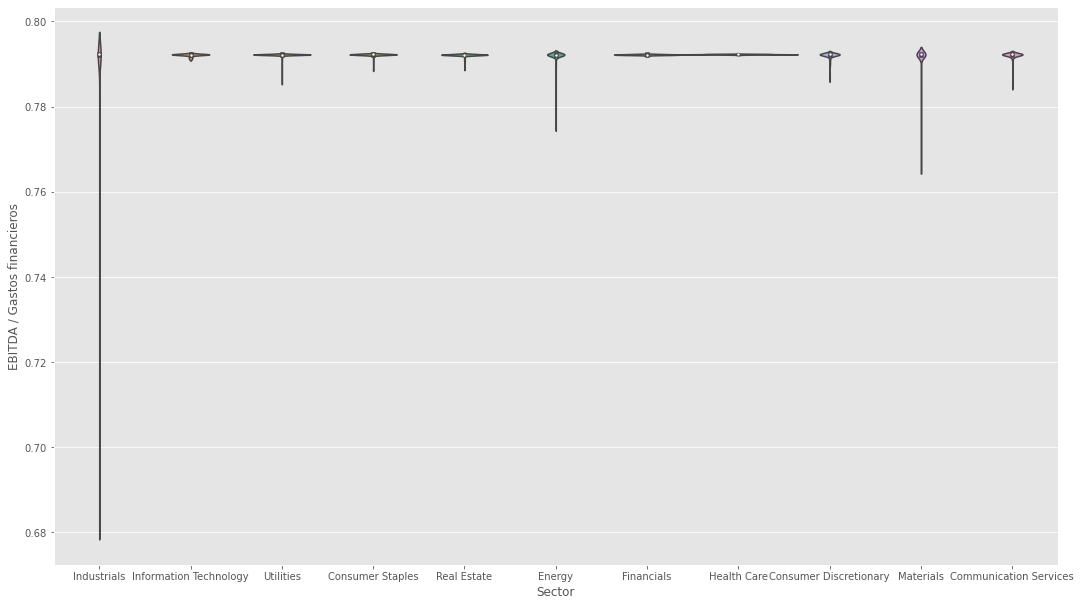

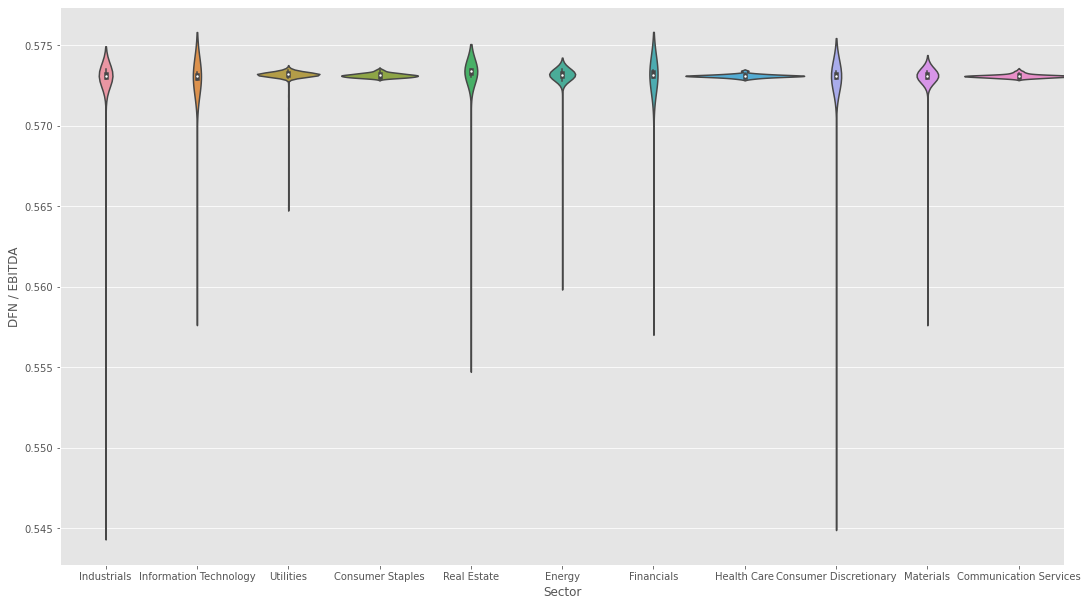

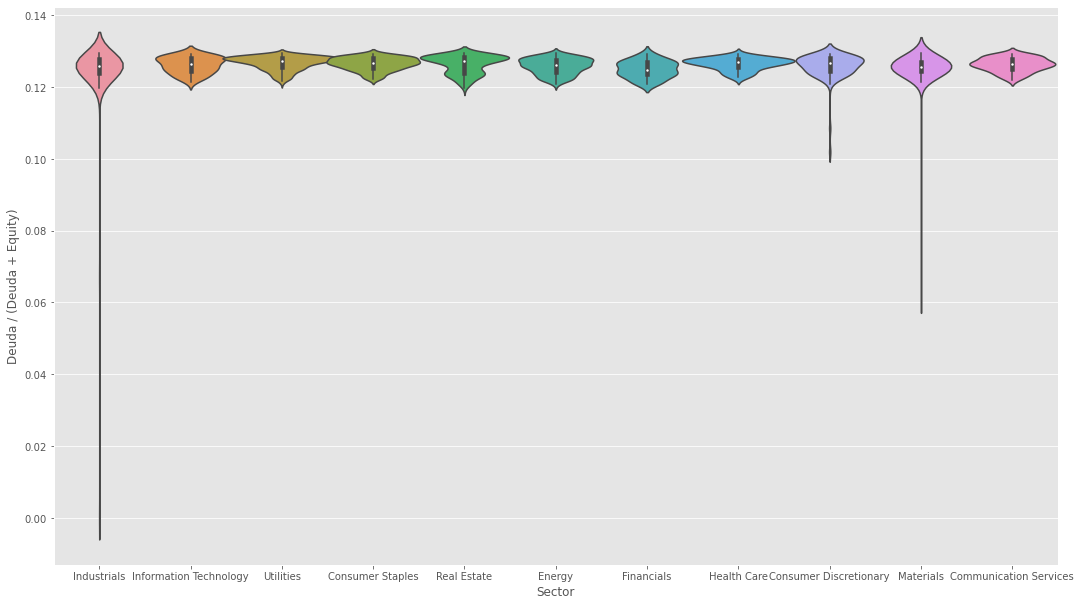

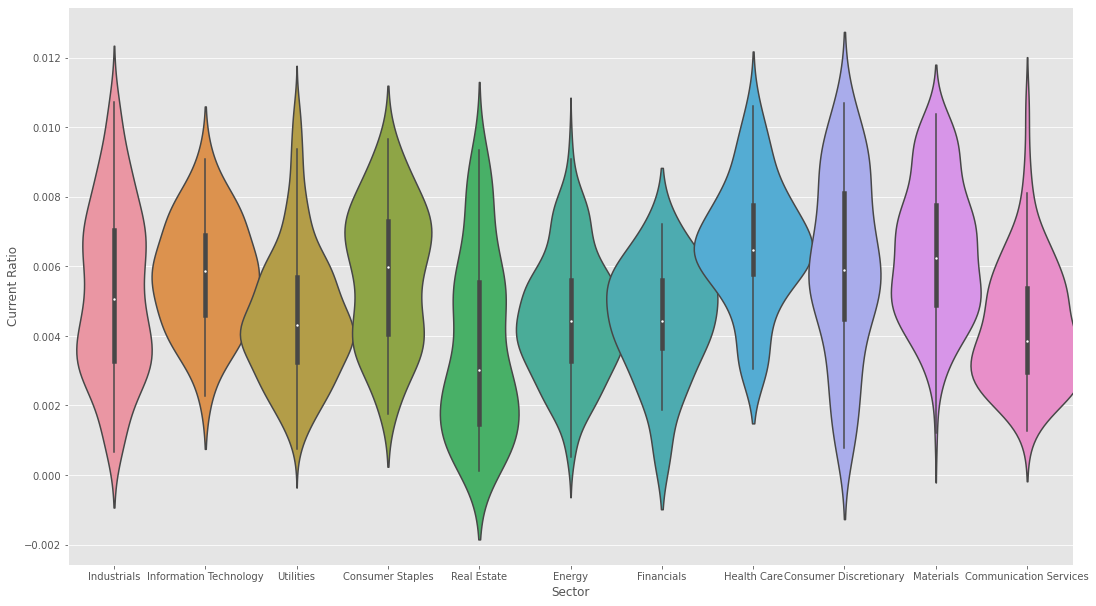

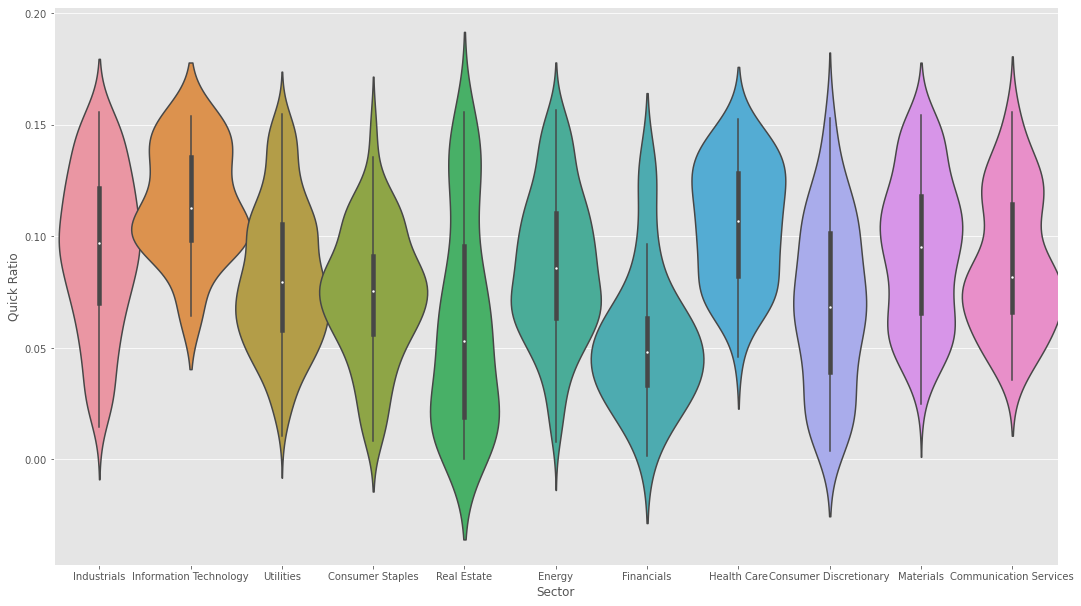

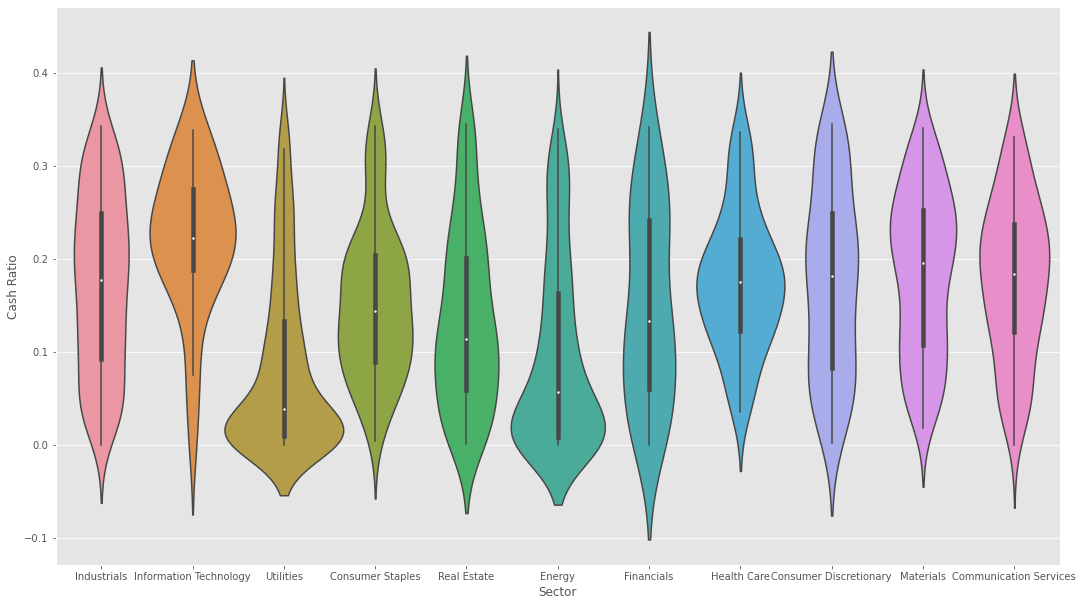

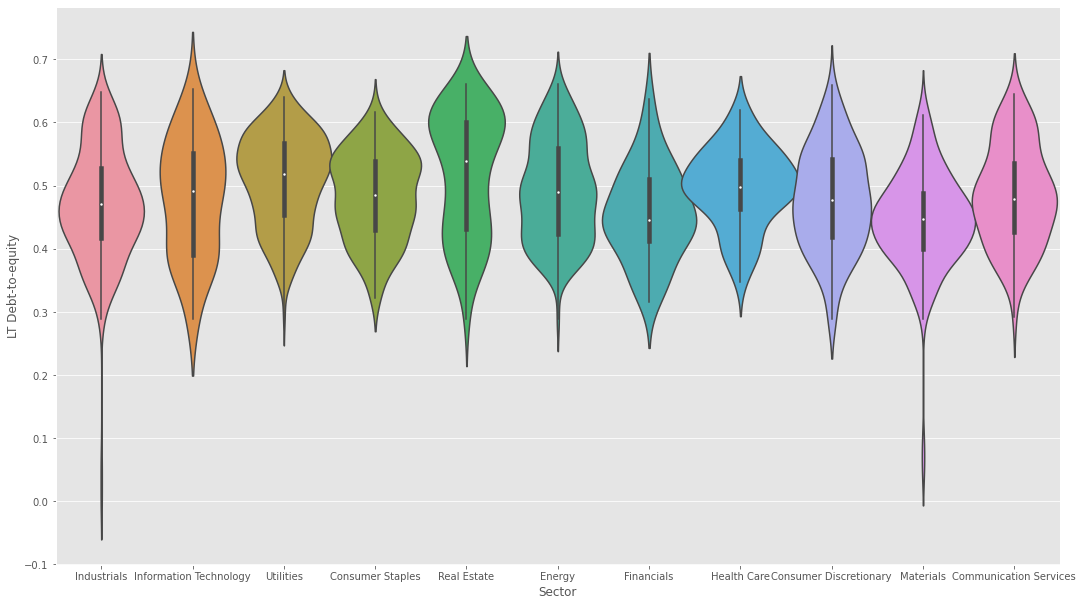

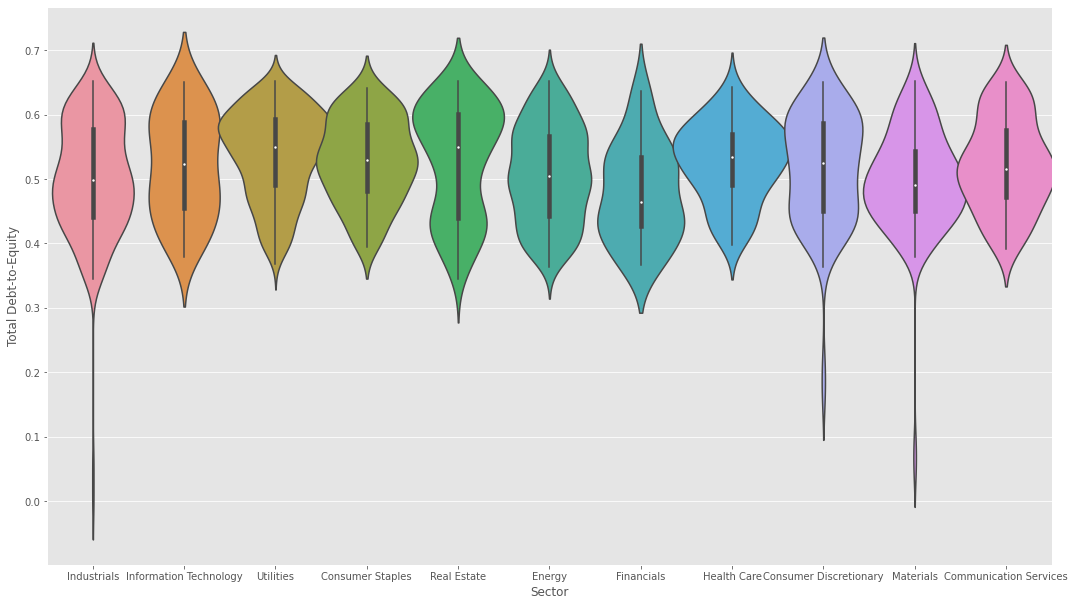

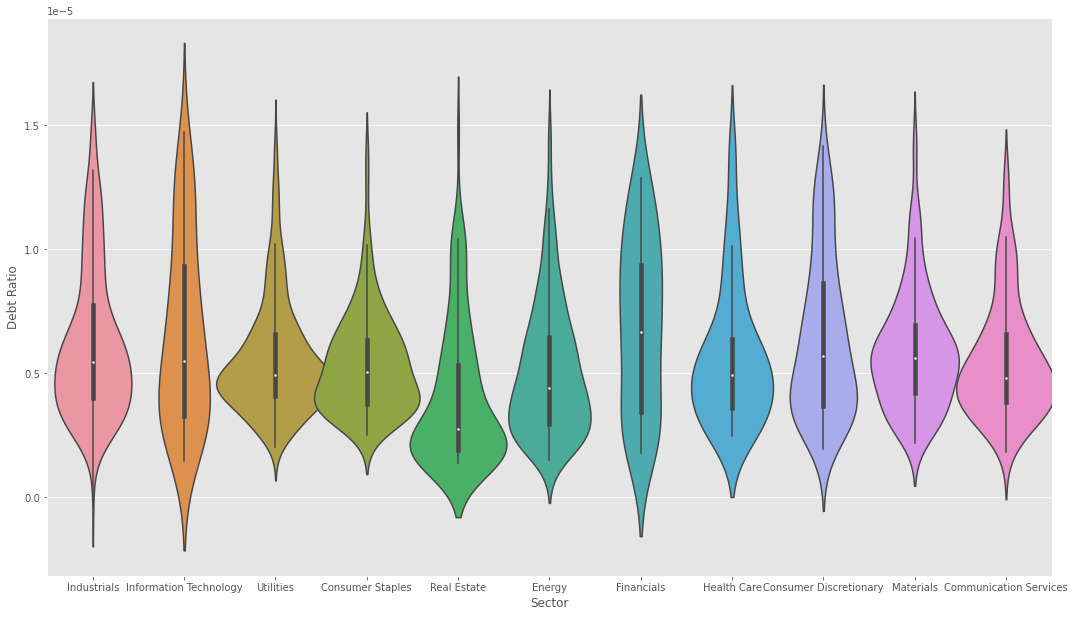

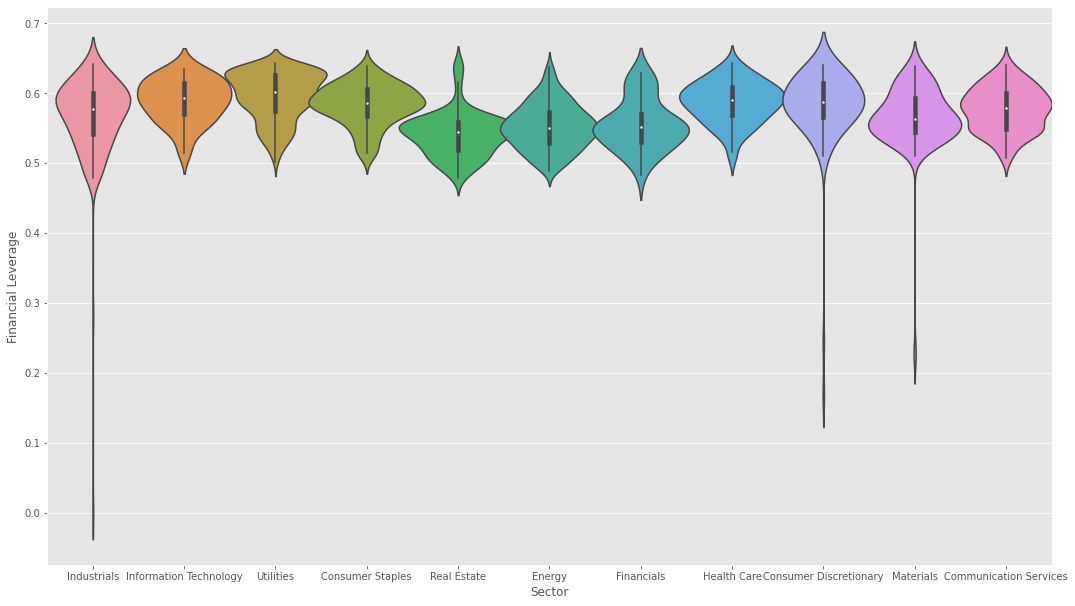

In [11]:
print(set(df['Sector']))
percentile = 0.2
for y in df.columns[3:]:
    df_mod = clean_df(df,df.columns,percentile)
    violin_plot(df_mod,'Sector', y)

Lo primero que haría es hacer un test estadístico para ver si las medias son estadisticamente diferentes entre ratings y sectores.

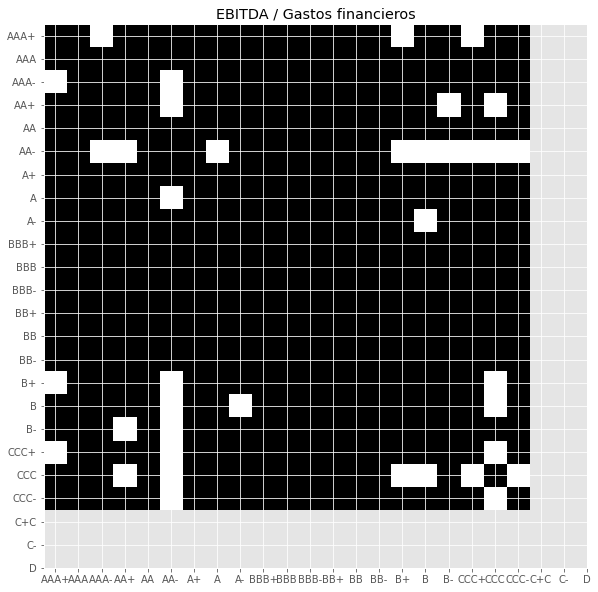

<Figure size 2160x720 with 0 Axes>

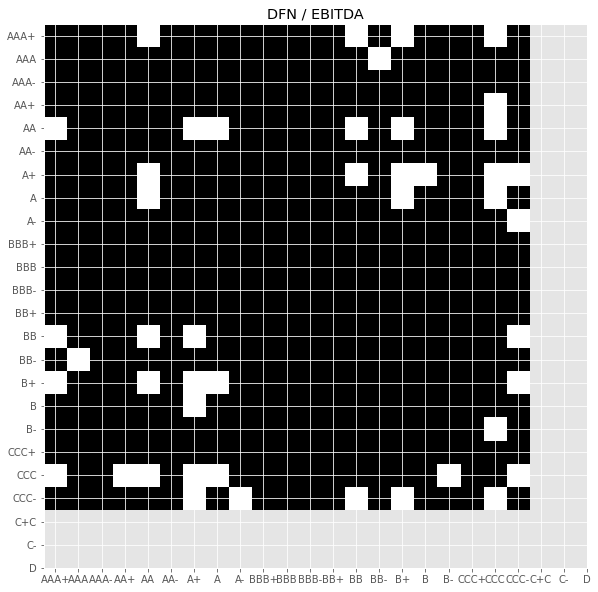

<Figure size 2160x720 with 0 Axes>

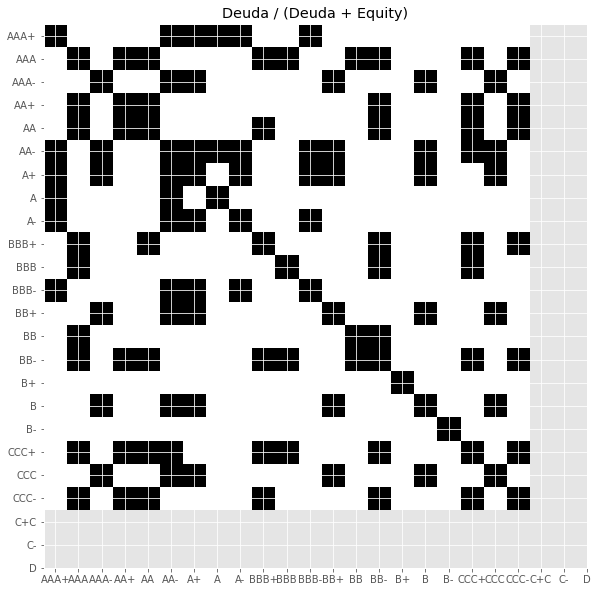

<Figure size 2160x720 with 0 Axes>

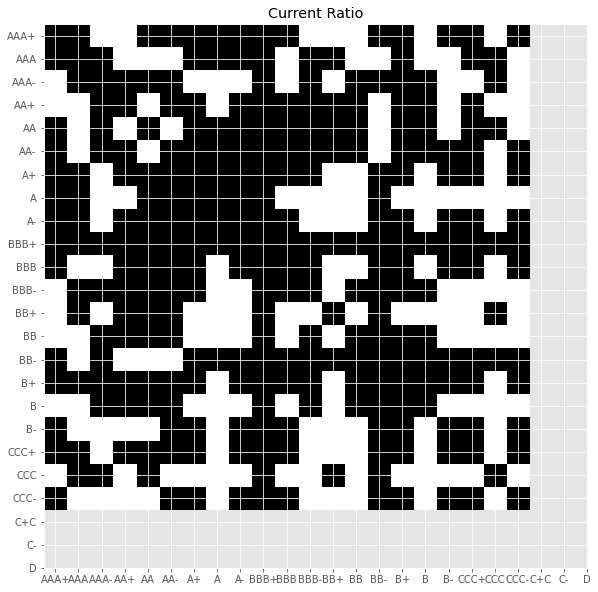

<Figure size 2160x720 with 0 Axes>

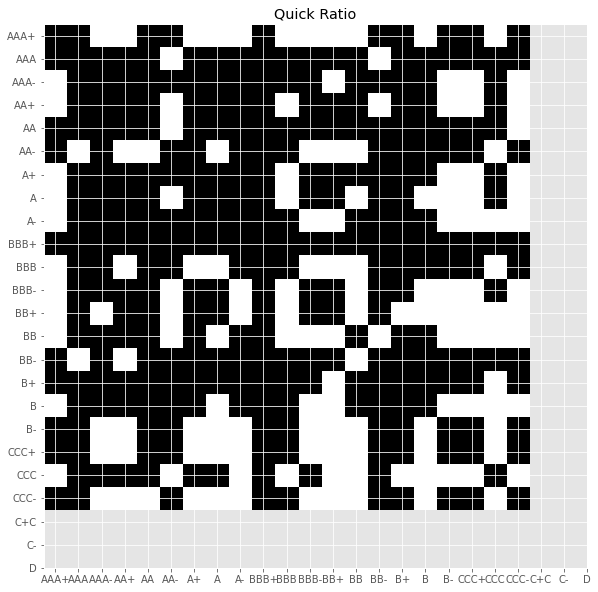

<Figure size 2160x720 with 0 Axes>

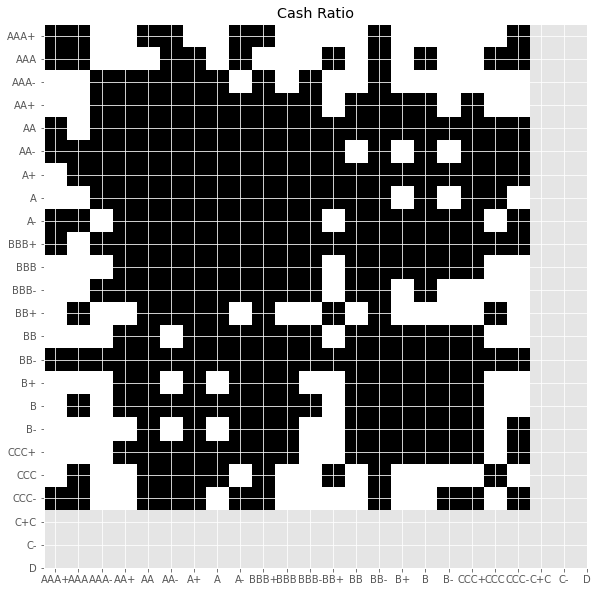

<Figure size 2160x720 with 0 Axes>

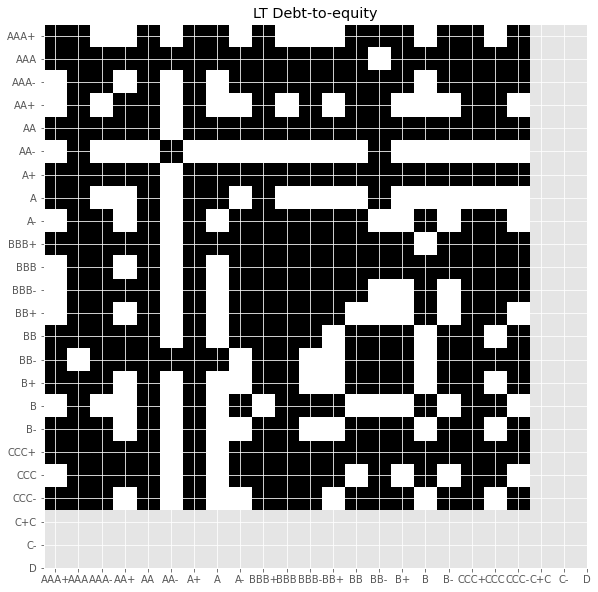

<Figure size 2160x720 with 0 Axes>

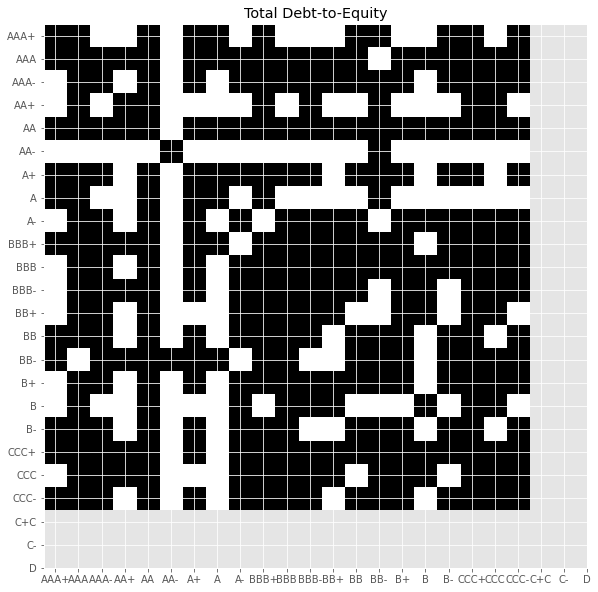

<Figure size 2160x720 with 0 Axes>

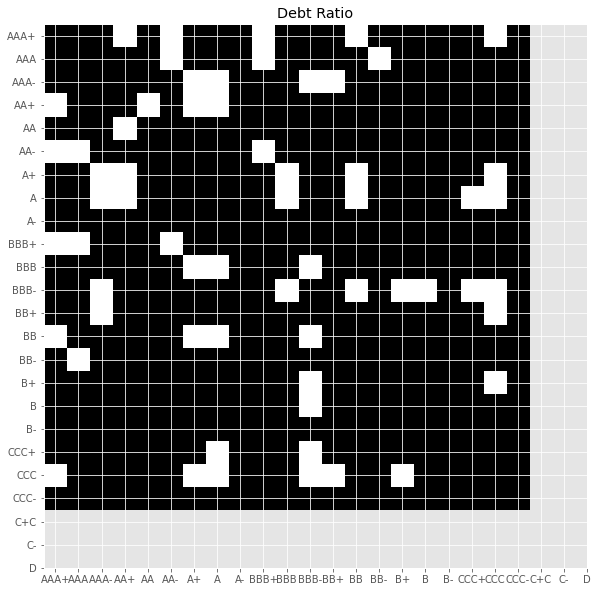

<Figure size 2160x720 with 0 Axes>

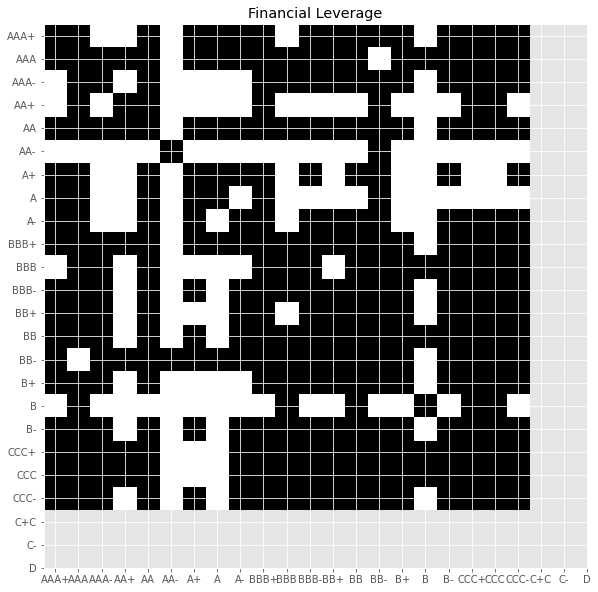

<Figure size 2160x720 with 0 Axes>

In [61]:
ratings = set(df['Rating'])
ratios = list(df.columns)[3:]
matrix = np.zeros((len(ratios),len(ratings),len(ratings)))

for i,ratio in enumerate(ratios):
    for j,rating1 in enumerate(ratings):
        for k,rating2 in enumerate(ratings):
            data1 = df[df['Rating'] == rating1][ratio]
            data2 = df[df['Rating'] == rating2][ratio]
            stat, p = ttest_ind(data1, data2)
#             print('Statistics=%.3f, p=%.3f' % (stat, p))
            alpha = 0.05
            if p > alpha:
                pass
#                 print('Same distributions (fail to reject H0): ', rating1,' vs ', rating2)
            else:
#                 print('O_O Different distributions (reject H0)', rating1,' vs ', rating2)
                matrix[i,j,k] = 1
    
size_plot = 10
for m,ratios in zip(matrix,ratios):
    fig = plt.figure(1, (size_plot * 1.6180, size_plot))

    plt.imshow(m,cmap = "gray",)
    plt.xticks([index for index, x in enumerate(All_rating_order)],
               All_rating_order)
    plt.yticks([index for index, x in enumerate(All_rating_order)],
               All_rating_order)
    plt.title(ratios)
    plt.figure(figsize=(30,10))
    plt.show()

In [62]:
ratings = set(df['Rating'])
ratios = list(df.columns)[3:]
matrix = np.array([])
p_values = []
alpha = 0.05
p_dict = {}

ratings_orde = []
#Ordenar los ratings
for rating in All_rating_order:
    if rating in ratings:
        ratings_orde.append(rating)
ratings = ratings_orde

#Construcción de un diccionario con los datos
for ratio in ratios:
    p_dict.update({ratio:{}})
    for rating1 in ratings:
        p_dict[ratio].update({rating1: {}})
        for rating2 in ratings:
            p_dict[ratio][rating1].update({rating2:999})
        
# print(p_dict)
#Rellenamos los datos
for ratio in ratios:
    for rating1 in ratings:
        for rating2 in ratings:
            data1 = df[df['Rating'] == rating1][ratio]
            data2 = df[df['Rating'] == rating2][ratio]
            stat, p = ttest_ind(data1, data2)
            p_dict[ratio][rating1][rating2]  = p
            p_values.append(p.round(4))
        matrix = np.concatenate((matrix,p_values))
        p_values = []
    matrix.reshape(len(ratings),len(ratings))
    matrix = np.array([])    

# print(p_dict)

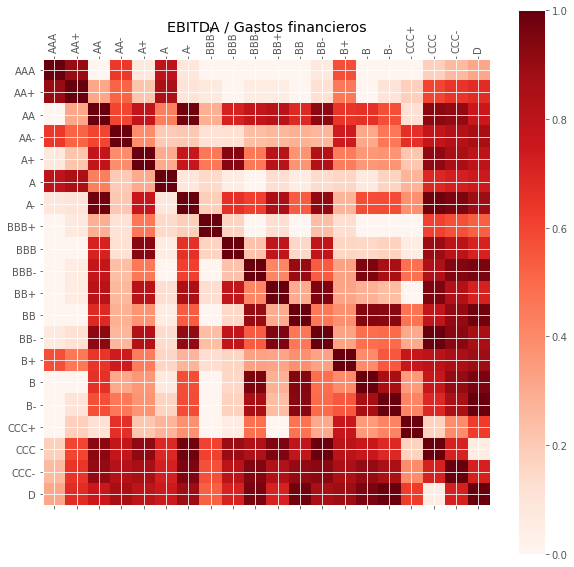

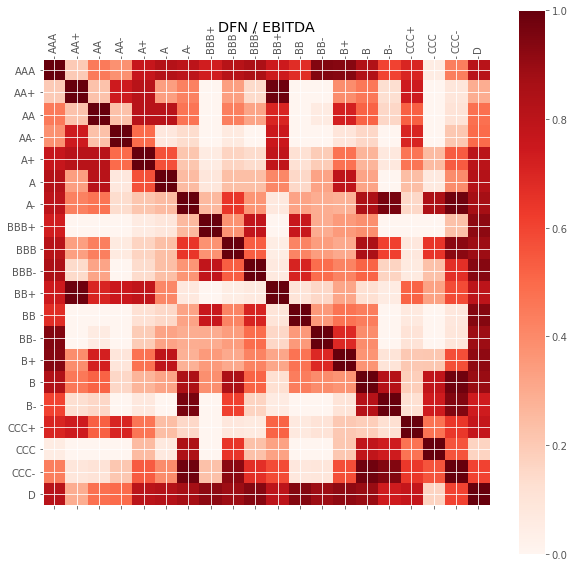

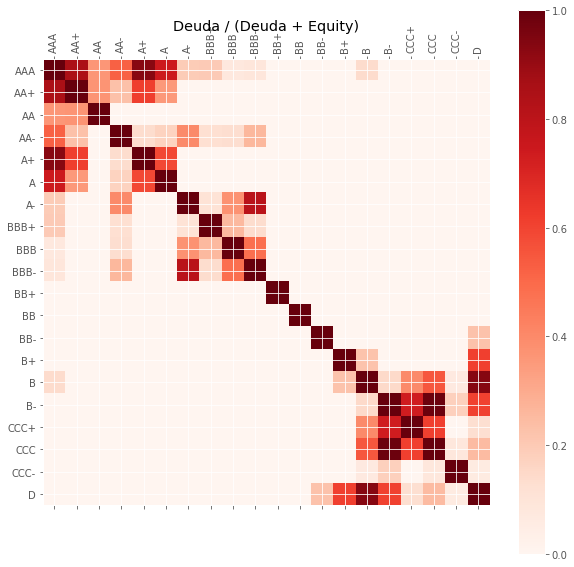

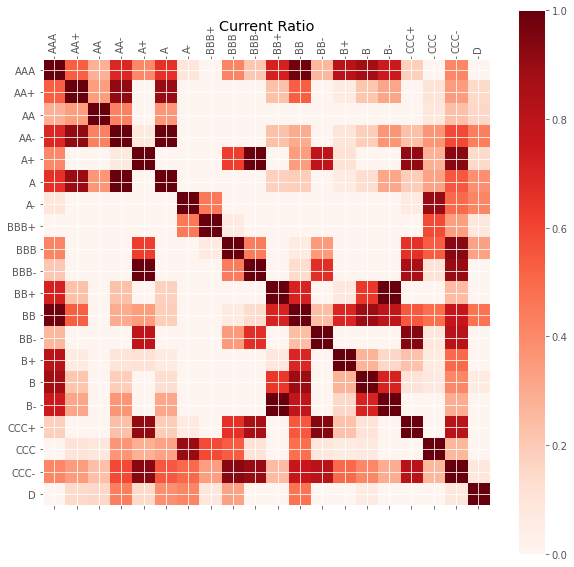

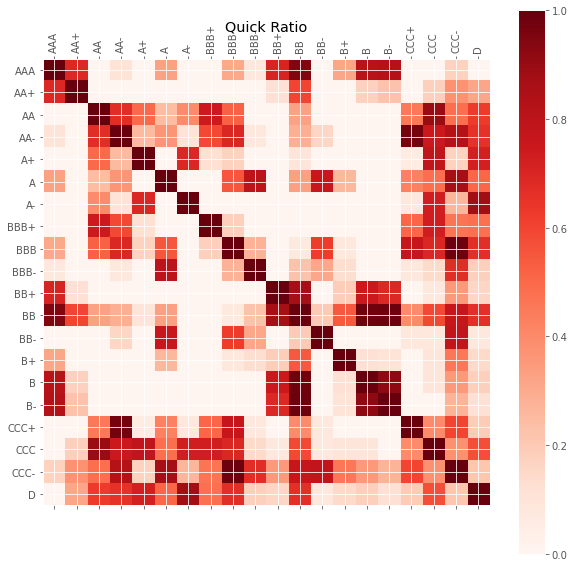

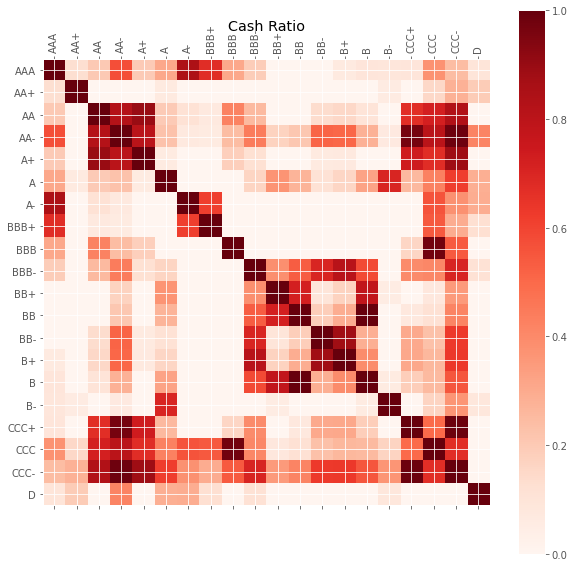

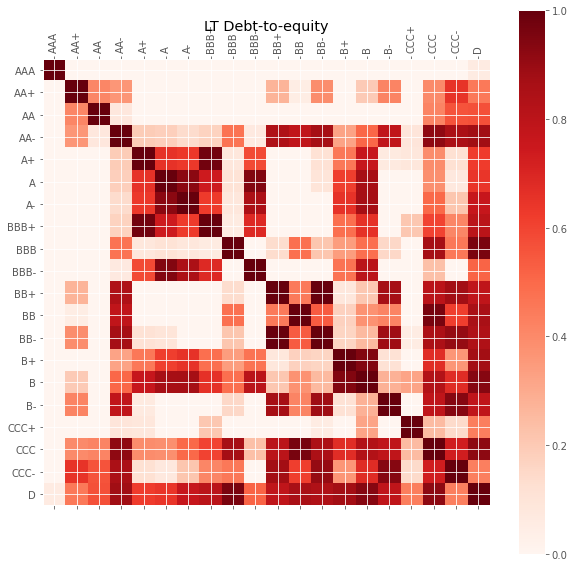

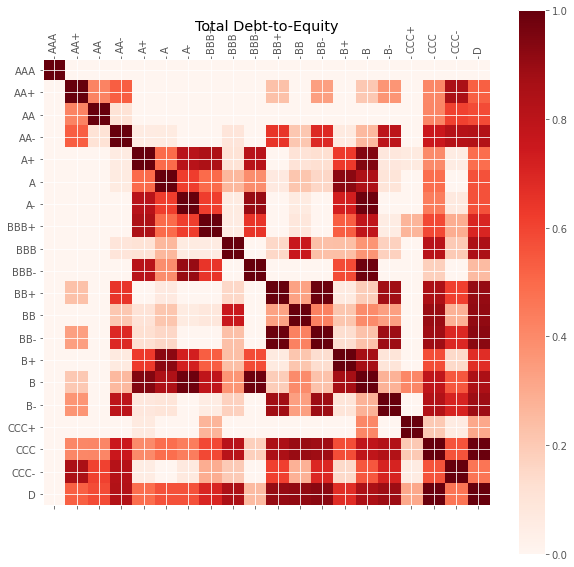

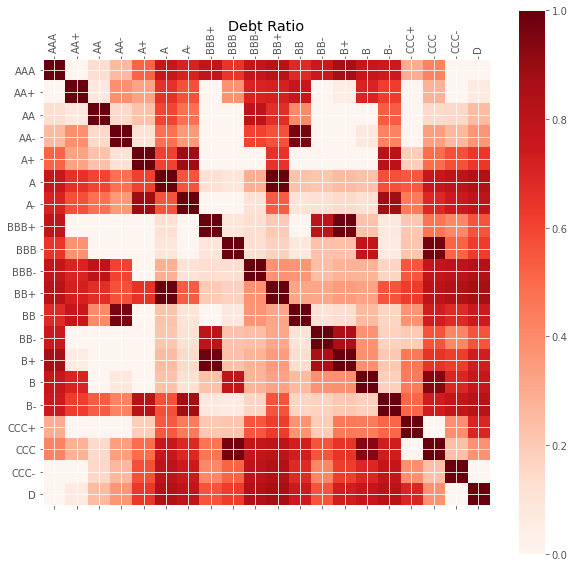

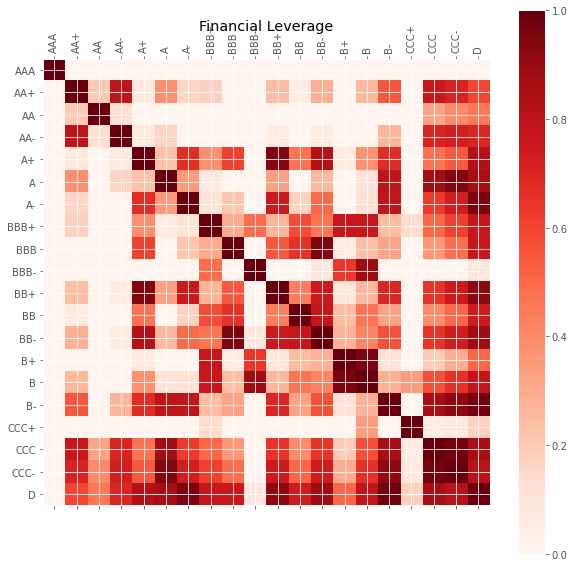

In [63]:
#Matriz de datos
corr = df.corr()

matrix = [] 
p_values = []

for ratio in ratios:
    for rating1 in ratings:
        for rating2 in ratings:
            if p_dict[ratio][rating1][rating2] > alpha:
                solution = p_dict[ratio][rating1][rating2]
            else:
                solution = 0
            p_values.append(solution)
        matrix.append(p_values)
#         print(len(p_values))
        p_values = []
#     print(rating1,matrix)
    size = 10
    fig, ax = plt.subplots(figsize=(size, size))
    car = ax.matshow(matrix, cmap = 'Reds')
    plt.xticks(range(len(ratings)), ratings,rotation = 90);
    plt.yticks(range(len(ratings)), ratings);
    fig.colorbar(car)
    plt.title(ratio)
    matrix = []



Ahora hacemos un estudio mas cuantitativo, para ver los sectores tines varibles significativamente diferentes.

**Fail to Reject H0:** La distribuciones muestrales son iguales

**Reject H0:** La distribuciones muestrales no son iguales

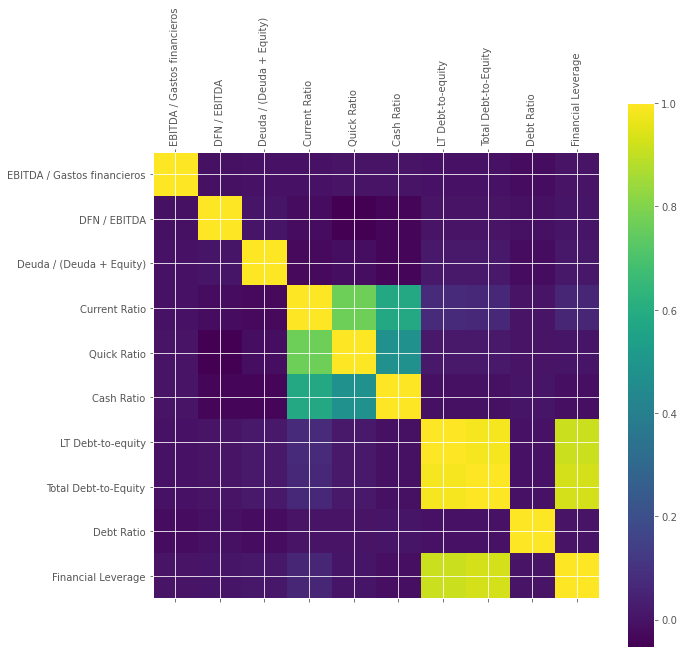

In [65]:
# buscar como ver la colinialidad entre ellas

def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    
    fig, ax = plt.subplots(figsize=(size, size))
    car = ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns,rotation = 90);
    plt.yticks(range(len(corr.columns)), corr.columns);
    fig.colorbar(car)
    
plot_corr(df)

Intentamos reducir la dispersión de los datos.

In [76]:
df.columns

Index(['ID', 'Rating', 'Sector', 'EBITDA / Gastos financieros', 'DFN / EBITDA',
       'Deuda / (Deuda + Equity)', 'Current Ratio', 'Quick Ratio',
       'Cash Ratio', 'LT Debt-to-equity', 'Total Debt-to-Equity', 'Debt Ratio',
       'Financial Leverage'],
      dtype='object')

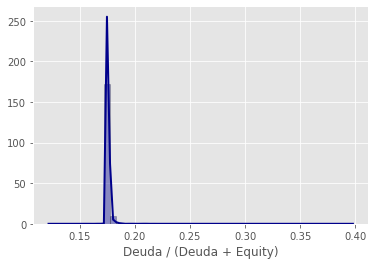

In [78]:
%matplotlib inline
c = df.columns[5]

sns.distplot(df[c], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})